# Table of Contents
1. [Import necessary libraries](#import)   
2. [Exploratory Data Analysis](#eda)  
    2.1 [Overview of train, test data and target variable](#overview)  
    2.2 [Detailed data analysis - Null values and correlation](#detailed)  
    2.3 [Detailed data analysis - Analysing discrete numeric variables](#discrete)  
    2.4 [Detailed data analysis - Analysing continuous numeric variables](#continuous)  
    2.5 [Detailed data analysis - Analysing categorical variables](#categorical)  
3. [Feature Engineering](#feature)  
    3.0 [Data Transformation - Drop Columns](#dropcolumn)  
    3.1 [Data Transformation - Removing Outliers](#outlier)  
    3.2 [Data Transformation - Dealing with categorical variables](#cat2num)  
    3.3 [Data Transformation - Imputing missing values](#impute)  
    3.4 [Data Transformation - Dealing with time variables](#time)  
    3.5 [Data Transformation - Categorical variables to dummy columns](#dummy)  
    3.6 [Final Dataset- Dropping unimportant features](#toomany)
4. [Machine Learning](#machine)  
    4.1 [Linear Regression](#linear)  
    4.2 [Lasso Regression](#lasso)  
    4.3 [Ridge Regression](#ridge)  
    4.4 [Randomforest Regression](#random)  
    4.5 [SVM Regression](#svm)  
    4.6 [GradientBoosting Regression](#gradient)  
    4.7 [Decision Tree Regression](#tree)  
5. [Conclusion](#conclusion)  
    


# 1. Import necessary libraries 
<a id="import"></a>

In [1561]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.widgets import Slider, Button, RadioButtons
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer 
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from pprint import pprint
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [1562]:
# funciones 
def check_missing_data(df_train):
    # missing data
    total = df_train.isnull().sum().sort_values(ascending=False)
    percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    
def OneH(df, columna):
    DF_dummies= pd.get_dummies(df[columna], prefix_sep="_#_", prefix = columna )
    df = pd.concat([df,DF_dummies], axis=1)
    return(df)

def distance(s_lat, s_lng, e_lat, e_lng):
    R = 6373.0
    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    return 2 * R * np.arcsin(np.sqrt(d)) 

# Calcula rmse
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


def GuardaResultado (algo,  train, test):
    if algo in dfResultados['Algoritmo'].values:
        dfResultados.loc[dfResultados['Algoritmo'] ==algo, 'Train'] = train
        dfResultados.loc[dfResultados['Algoritmo'] ==algo, 'Test'] = test
    else:
        dfResultados.loc[len(dfResultados)]=[algo, train,test] 
    

In [1563]:
dfResultados = pd.DataFrame(columns=('Algoritmo', 'Train', 'Test'))

# 2 Exploratory Data Analysis
<a id="eda"></a>

## 2.1 Overview of train, test data and target variable 
<a id="overview"></a>

In [1736]:
# cargamos datos
house_data_raw = pd.read_csv("./data/airbnb-listings.csv", sep=';') # cargamos fichero
pd.set_option('display.max_columns', len(house_data_raw.columns))

Existen 14780 observaciones con 89 características.

In [1737]:
house_data_raw.shape

(14780, 89)

In [1565]:
house_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
ID                                14780 non-null int64
Listing Url                       14780 non-null object
Scrape ID                         14780 non-null int64
Last Scraped                      14780 non-null object
Name                              14779 non-null object
Summary                           14189 non-null object
Space                             10888 non-null object
Description                       14774 non-null object
Experiences Offered               14780 non-null object
Neighborhood Overview             9134 non-null object
Notes                             5644 non-null object
Transit                           9066 non-null object
Access                            8318 non-null object
Interaction                       8228 non-null object
House Rules                       9619 non-null object
Thumbnail Url                     11960 non-null object
Med

Si ponemos el foco en los barrios, la mayoria son barrios del municipio de Madrid.

In [1566]:
house_data_raw['Neighbourhood Group Cleansed'].value_counts()


Centro                      6780
Chamberí                     960
Salamanca                    883
Arganzuela                   793
Tetuán                       464
Moncloa - Aravaca            450
Retiro                       439
Latina                       379
Chamartín                    361
Carabanchel                  358
Ciudad Lineal                309
Puente de Vallecas           222
Hortaleza                    186
Fuencarral - El Pardo        170
Usera                        145
Eixample                     124
San Blas - Canillejas        118
Villaverde                    83
Barajas                       81
Moratalaz                     74
Villa de Vallecas             46
Gràcia                        41
Ciutat Vella                  41
Sants-Montjuïc                39
Manhattan                     35
Vicálvaro                     34
Brooklyn                      28
Les Corts                     15
Sant Martí                    14
Isole                         13
Sarrià-San

Ademas de que el 95% son alojamientos en España

In [1567]:
house_data_raw['Country Code'].value_counts(1)*100


ES    94.729364
US     1.244926
GB     1.075778
FR     0.744249
IT     0.460081
AU     0.311231
IE     0.304465
DE     0.277402
AT     0.209743
NL     0.175913
CA     0.135318
BE     0.115020
DK     0.108254
CH     0.040595
GR     0.033829
HK     0.020298
CU     0.006766
It     0.006766
Name: Country Code, dtype: float64

Si analizamos la variable State, podemos observar que la inmensa mayoria son descriptivos de la Comunidad de Madrid, en diferentes menciones.

In [1568]:
house_data_raw['State'].value_counts()

Comunidad de Madrid    10623
Community of Madrid     1887
Madrid                   677
Catalunya                187
Balearic Islands         176
                       ...  
Madrid \nMadrid            1
Copenhagen                 1
Alicante                   1
Madrid España              1
Espańa                     1
Name: State, Length: 102, dtype: int64

Por lo tanto, decido solamente llevar a cabo el estudio para los alojamientos situados en Madrid, eliminado el resto.  
Cabe destacar la labor de limpieza para poder aprovechar cada registro proporcionado.
Al estrechar el foco hacia Madrid, las variables 'City','State','Zipcode','Market','Smart Location','Street','Country Code','Country', dejan de tener peso en el análisis.  

Eliminamos también las variables 'ID','Listing Url', 'Scrape ID', 'Last Scraped','Name','Summary','Space','Description','Neighborhood Overview','Neighbourhood','Neighbourhood Cleansed', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 'Host Location', 'Host About', 'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood',  'Calendar last Scraped', 'Geolocation', por su poco valor a la hora de llegar a nuestro objetivo que es predecir el precio de los alojamientos.

In [1569]:
house_data_raw = house_data_raw.loc[house_data_raw['Country Code'] == 'ES']
mencionesState_Madrid = ['Comunidad de Madrid',
'Community of Madrid',
'Communauté de Madrid',
'MADRID',
'Madrid',
'madrid',
'Spain',
'Região Autônoma de Madrid',
'Autonome Gemeinschaft Madrid',
'Madrid \nMadrid',
'España,Madrid',
'Madrid España',
'Madrid capital',
'Espańa',
'Madrid, Spain',
'28',
'Usera']
filter1 = house_data_raw['State'].isin(mencionesState_Madrid) 
filter2 = house_data_raw['State'].isna()
house1 = house_data_raw[filter1]
house2 = house_data_raw[filter2]
house2 = house2.loc[house2['City']=='Madrid']
frames = [house1, house2]
house_data_raw = pd.concat(frames)
#house_data_raw[['City','State','Zipcode','Market','Smart Location','Street','Country Code','Country']]
house_data_raw.drop(['City','State','Zipcode','Market','Smart Location','Street','Country Code','Country'], inplace= True, axis=1)
cols_to_drop = ['ID','Listing Url', 'Scrape ID', 'Last Scraped','Name','Summary','Space','Description','Neighborhood Overview','Neighbourhood','Neighbourhood Cleansed', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 'Host Location', 'Host About', 'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood',  'Calendar last Scraped', 'Geolocation']
house_data_raw.drop(cols_to_drop, inplace= True, axis = 1 )

Separamos los datos en conjuntos de Train y Test, y objetivo train y test (y_train, y_test)

In [1570]:
X,y = house_data_raw.drop(['Price'], axis=1 ), house_data_raw['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.20, random_state =0)

Vemos su distribución, totalmente escorada.

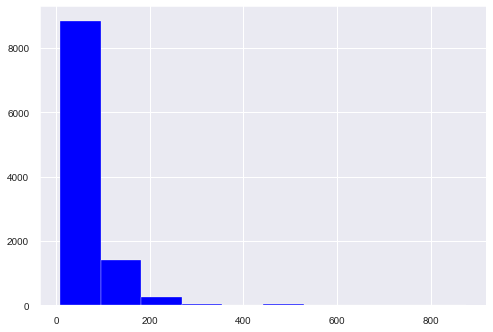

In [1571]:
plt.hist(y_train, color ='blue')
plt.show()
#The data is skewed, hence to normalise it we will use log. Kaggle will also use the same method to evaluate

In [1572]:
y_train.describe()

count    10604.000000
mean        65.971520
std         55.937216
min          9.000000
25%         31.000000
50%         52.000000
75%         80.000000
max        875.000000
Name: Price, dtype: float64

Decido aplicar a las variables target log, para que de esa forma sea lo más parecido a una distribución normal, no tan sesgada como la inicial.

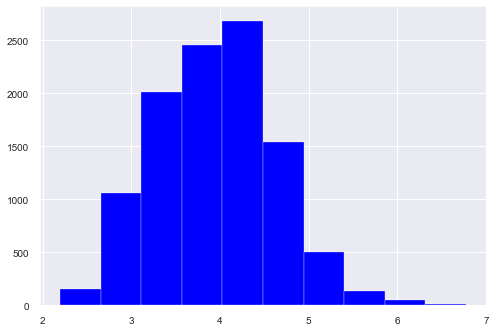

In [1573]:
y_train=np.log(y_train)
plt.hist(y_train, color='blue')
plt.show()

In [1574]:
# Lo realizamos tambien para el conjunto de test
y_test=np.log(y_test)

# tratamos los valores missing
media = y_train.mean()
y_train.fillna(media, inplace= True)
y_test.fillna(media, inplace= True)

Datos de Train, 10611 observaciones con 50 columnas.

In [1575]:
#Train
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10611 entries, 8899 to 3261
Data columns (total 50 columns):
Experiences Offered               10611 non-null object
Host Since                        10610 non-null object
Host Response Time                9283 non-null object
Host Response Rate                9283 non-null float64
Host Acceptance Rate              0 non-null object
Host Listings Count               10610 non-null float64
Host Total Listings Count         10610 non-null float64
Host Verifications                10605 non-null object
Neighbourhood Group Cleansed      10611 non-null object
Latitude                          10611 non-null float64
Longitude                         10611 non-null float64
Property Type                     10611 non-null object
Room Type                         10611 non-null object
Accommodates                      10611 non-null int64
Bathrooms                         10570 non-null float64
Bedrooms                          10594 non-null f

Experiences Offered  Host Since  Host Response Time  Host Response Rate  \
8899                none  2015-04-13        within a day               100.0   
1236                none  2017-04-01                 NaN                 NaN   
2945                none  2015-05-31  within a few hours               100.0   
2384                none  2015-12-30        within a day                90.0   
8874                none  2015-10-01                 NaN                 NaN   

     Host Acceptance Rate  Host Listings Count  Host Total Listings Count  \
8899                  NaN                  1.0                        1.0   
1236                  NaN                  1.0                        1.0   
2945                  NaN                  2.0                        2.0   
2384                  NaN                  3.0                        3.0   
8874                  NaN                  1.0                        1.0   

                                   Host Verifications  \
8899          email,phone,reviews,jumio,government_id   
1236  email,jumio,offline_government_id,government_id   
2945                              email,phone,reviews   
2384                     email,phone,facebook,reviews   
8874                       email,phone,facebook,jumio   

     Neighbourhood Group Cleansed   Latitude  Longitude    Property Type  \
8899                Ciudad Lineal  40.427726  -3.655648            Other   
1236           Puente de Vallecas  40.392133  -3.666384  Bed & Breakfast   
2945                       Centro  40.409608  -3.710649        Apartment   
2384                       Centro  40.409424  -3.705527        Apartment   
8874                       Retiro  40.416913  -3.666427        Apartment   

            Room Type  Accommodates  Bathrooms  Bedrooms  Beds  Bed Type  \
8899     Private room             2        1.0       1.0   1.0  Real Bed   
1236     Private room             2        1.0       1.0   1.0  Real Bed   
2945  Entire home/apt             2        1.0       1.0   1.0  Real Bed   
2384     Private room             1        1.0       1.0   1.0  Real Bed   
8874     Private room             2        1.0       1.0   1.0  Real Bed   

                                              Amenities  Square Feet  \
8899  Wireless Internet,Kitchen,Heating,Washer,Essen...          NaN   
1236                   Pets allowed,Family/kid friendly          NaN   
2945  TV,Wireless Internet,Kitchen,Heating,Washer,Es...          NaN   
2384  Internet,Wireless Internet,Air conditioning,Ki...          NaN   
8874  TV,Wireless Internet,Kitchen,Washer,Laptop fri...          NaN   

      Weekly Price  Monthly Price  Security Deposit  Cleaning Fee  \
8899           NaN            NaN               NaN           NaN   
1236           NaN            NaN               NaN           NaN   
2945           NaN            NaN             100.0           NaN   
2384           NaN            NaN               NaN          10.0   
8874           NaN            NaN               NaN          15.0   

      Guests Included  Extra People  Minimum Nights  Maximum Nights  \
8899                1             0               2              10   
1236                1             0               2            1125   
2945                1             0               5            1125   
2384                1             0               1            1125   
8874                1             0               2              20   

     Calendar Updated Has Availability  Availability 30  Availability 60  \
8899       a week ago              NaN                6               32   
1236            never              NaN               30               60   
2945      2 weeks ago              NaN                1                1   
2384            today              NaN               24               54   
8874      2 weeks ago              NaN                0                0   

      Availability 90  Availability 365  Number of Reviews First Review 

In [1576]:
#Numeric Features
numeric_features = X_train.select_dtypes(include=[np.number])
numeric_features.dtypes

Host Response Rate                float64
Host Listings Count               float64
Host Total Listings Count         float64
Latitude                          float64
Longitude                         float64
Accommodates                        int64
Bathrooms                         float64
Bedrooms                          float64
Beds                              float64
Square Feet                       float64
Weekly Price                      float64
Monthly Price                     float64
Security Deposit                  float64
Cleaning Fee                      float64
Guests Included                     int64
Extra People                        int64
Minimum Nights                      int64
Maximum Nights                      int64
Availability 30                     int64
Availability 60                     int64
Availability 90                     int64
Availability 365                    int64
Number of Reviews                   int64
Review Scores Rating              

In [1577]:
#Categorical Features
categoricals = X_train.select_dtypes(exclude=[np.number])
print(categoricals.dtypes)
categoricals.describe()

Experiences Offered             object
Host Since                      object
Host Response Time              object
Host Acceptance Rate            object
Host Verifications              object
Neighbourhood Group Cleansed    object
Property Type                   object
Room Type                       object
Bed Type                        object
Amenities                       object
Calendar Updated                object
Has Availability                object
First Review                    object
Last Review                     object
License                         object
Jurisdiction Names              object
Cancellation Policy             object
Features                        object
dtype: object


Experiences Offered  Host Since Host Response Time  \
count                10611       10610               9283   
unique                   1        1998                  4   
top                   none  2014-09-19     within an hour   
freq                 10611         127               5702   

       Host Acceptance Rate   Host Verifications Neighbourhood Group Cleansed  \
count                     0                10605                        10611   
unique                    0                  174                           21   
top                     NaN  email,phone,reviews                       Centro   
freq                    NaN                 2674                         5398   

       Property Type        Room Type  Bed Type  \
count          10611            10611     10611   
unique            21                3         5   
top        Apartment  Entire home/apt  Real Bed   
freq            8746             6361     10374   

                                                Amenities Calendar Updated  \
count                                               10520            10611   
unique                                               9039               56   
top     TV,Internet,Wireless Internet,Air conditioning...            today   
freq                                                   36             2749   

       Has Availability First Review Last Review License Jurisdiction Names  \
count                 0         8420        8419     198                  0   
unique                0         1495         661     195                  0   
top                 NaN   2016-10-09  2017-04-02  VT1046                NaN   
freq                NaN           56         606       2                NaN   

       Cancellation Policy                                           Features  
count                10611                                              10611  
unique                   5                                                 57  
top                 strict  Host Has Profile Pic,Host Identity Verified,Is...  
freq                  3970                                               1906

Combinamos los dos conjuntos de datos (Train and Test), este paso será muy util para la parte de <b>Feature Engineering</b>

In [1578]:
#Combining train and test
X_train_copy=X_train.copy()

combined=X_train_copy.append(X_test)
combined.reset_index(inplace=True)



## 2.2 Detailed data analysis - Null values and correlation
<a id="detailed"></a>

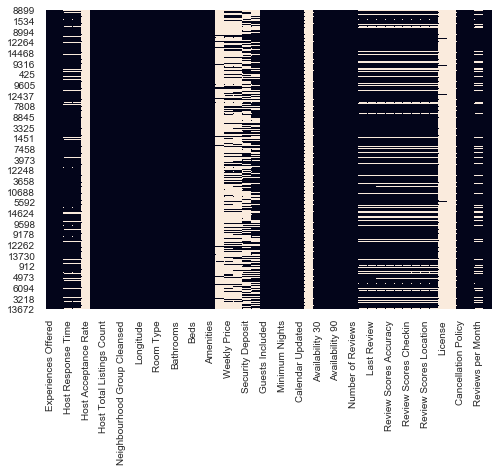

In [1579]:
#Null values in the train dataset
sns.heatmap(X_train.isnull(), cbar=False)

In [1580]:
#Correlation
## adding Price to X_train numeric features
numeric_features['Price'] = y_train
corr = numeric_features.corr()
print(corr['Price'].sort_values(ascending=False)[:5],'\n')
print(corr['Price'].sort_values(ascending=False)[-5:],'\n')

Price            1.000000
Weekly Price     0.866559
Monthly Price    0.731503
Accommodates     0.611717
Cleaning Fee     0.586641
Name: Price, dtype: float64 

Reviews per Month   -0.017434
Longitude           -0.041978
Availability 30     -0.049713
Availability 60     -0.051523
Availability 90     -0.059554
Name: Price, dtype: float64 



In [1581]:
print(corr['Price'].sort_values(ascending=False))

Price                             1.000000
Weekly Price                      0.866559
Monthly Price                     0.731503
Accommodates                      0.611717
Cleaning Fee                      0.586641
Bedrooms                          0.463106
Beds                              0.433232
Guests Included                   0.417175
Security Deposit                  0.324442
Square Feet                       0.231179
Bathrooms                         0.222098
Review Scores Location            0.208884
Host Listings Count               0.179116
Host Total Listings Count         0.179116
Calculated host listings count    0.148332
Extra People                      0.138485
Review Scores Cleanliness         0.106080
Latitude                          0.098892
Availability 365                  0.080619
Review Scores Accuracy            0.073429
Review Scores Rating              0.068390
Number of Reviews                 0.032233
Review Scores Value               0.027218
Host Respon

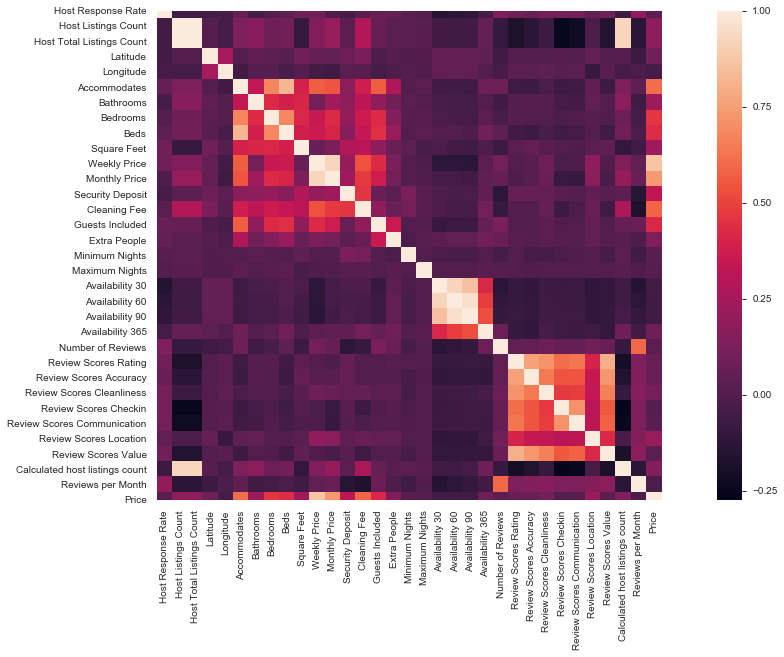

In [1582]:
plt.subplots(figsize=(20, 9))
sns.heatmap(corr, square=True)

Podemos apreciar cuatro grupos definidos claramente. El grupo de Price, Weekly Price y Monthly Price, otro grupo que sería las características de Availability. El tercer grupo que serían el grupo de las Review, y por último Host Listing. Para este ultimo grupo voy a probar si existe multicolinealidad entre dichas variables realizando una regresión lineal.  
Existe un cuarto grupo no tan definido que relaciona Bedrooms, Beds, Accommodates, pero las considero básicas para el objetivo de la practica.

<b>Grupo Host Listing</b>

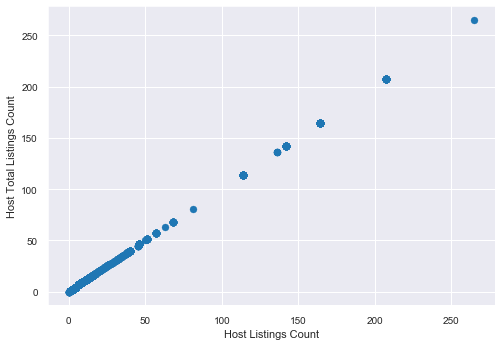

In [1583]:
plt.scatter(x=combined['Host Listings Count'],y=combined['Host Total Listings Count'])
plt.xlabel('Host Listings Count')
plt.ylabel('Host Total Listings Count')
plt.show()
# 

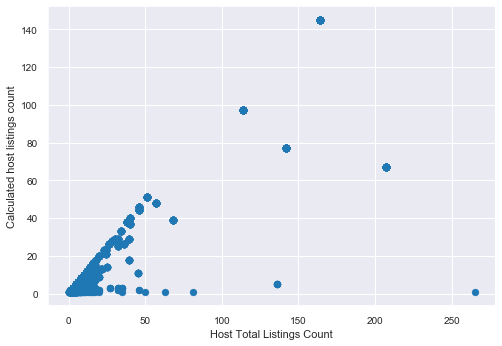

In [1584]:
plt.scatter(x=combined['Host Total Listings Count'],y=combined['Calculated host listings count'])
plt.xlabel('Host Total Listings Count')
plt.ylabel('Calculated host listings count')
plt.show()
# Existe una cierta correlación entre las tres variables nos quedaremos con las que menos missing value posea, 
#Calculated host listings count

Existe relación por tanto Calculated host listings count Host Listings Count  puede representarse mediante una ecuación lineal de las características Host Total Listings Count y  Host Listings Count.

In [1585]:
combined[['Host Listings Count', 'Host Total Listings Count','Calculated host listings count']].isna().sum()

Host Listings Count               3
Host Total Listings Count         3
Calculated host listings count    0
dtype: int64

El grupo de <b>Price, Weekly Price y Monthly Price</b>

In [1586]:
numeric_features[['Price', 'Weekly Price', 'Monthly Price']].isna().sum()

Price               0
Weekly Price     7929
Monthly Price    7959
dtype: int64

apreciamos que las variables 'Weekly Price', 'Monthly Price' poseen mas de un 74% de missing value por tanto las eliminaremos

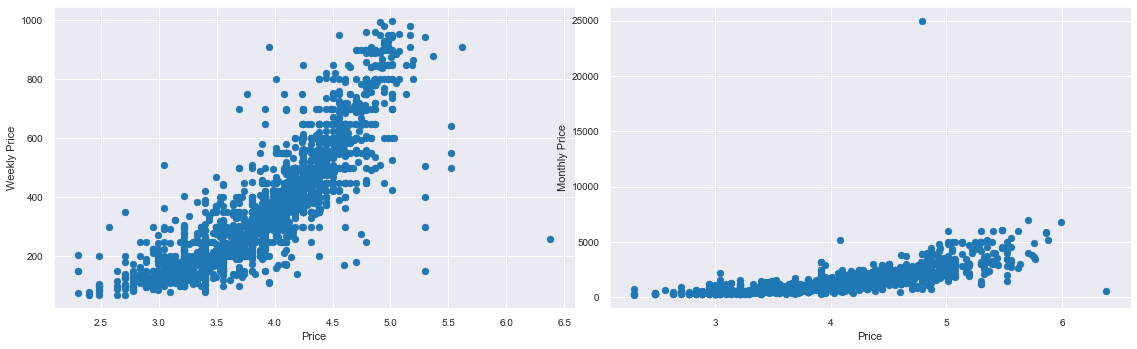

In [1587]:
sns.set_style('darkgrid')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.tight_layout()
plt.scatter(x=numeric_features['Price'],y=numeric_features['Weekly Price'])
plt.xlabel('Price')
plt.ylabel('Weekly Price')

plt.subplot(1,2,2)
plt.tight_layout()
plt.scatter(x=numeric_features['Price'],y=numeric_features['Monthly Price'])
plt.xlabel('Price')
plt.ylabel('Monthly Price')

plt.show()

#### Number of Reviews and Reviews per Month

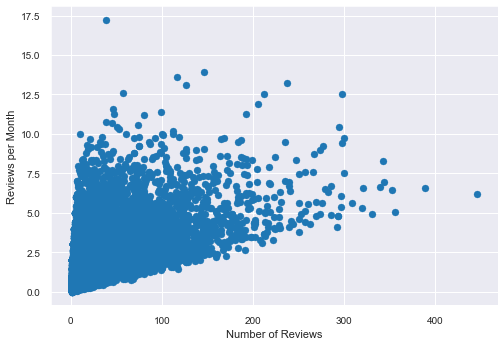

In [1588]:
plt.scatter(x=combined['Number of Reviews'],y=combined['Reviews per Month'])
plt.xlabel('Number of Reviews')
plt.ylabel('Reviews per Month')
plt.show()

Existe una clara correlación. 

In [1589]:
numeric_features[['Number of Reviews', 'Reviews per Month']].isna().sum()

Number of Reviews       0
Reviews per Month    2191
dtype: int64

Nos quedaremos con la variable Number of Reviews ya que no posee missing value, facilitando el trabajo.

Exister algo de correlación, pero considero estas variables imprescindibles para el objetivo de la practica, por este hecho no las voy a eliminar.

## 2.3 Detailed data analysis - Analysing discrete numeric variables
<a id="discrete"></a>

<b>Grupo Review</b>

Realizamos un proceso de regresión lineal para ver si son independiente. He decidido en este caso este procedimiento para variar un poco, ya que se puede emplear diversos métodos.

In [1590]:
review_df = numeric_features[['Review Scores Rating', 'Review Scores Accuracy','Review Scores Cleanliness', 'Review Scores Checkin','Review Scores Communication', 'Review Scores Location','Review Scores Value']]
review_df2 = review_df.dropna()
y = review_df2['Review Scores Rating'] /10
x = review_df2.drop(['Review Scores Rating'], axis=1 )
est = sm.OLS(y, x).fit()
print(est.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Review Scores Rating   R-squared (uncentered):                   0.998
Model:                              OLS   Adj. R-squared (uncentered):              0.998
Method:                   Least Squares   F-statistic:                          6.224e+05
Date:                  Sun, 02 Feb 2020   Prob (F-statistic):                        0.00
Time:                          17:11:29   Log-Likelihood:                         -4815.1
No. Observations:                  8279   AIC:                                      9642.
Df Residuals:                      8273   BIC:                                      9684.
Df Model:                             6                                                  
Covariance Type:              nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
----

Podemos observar que son bastantes parecidas

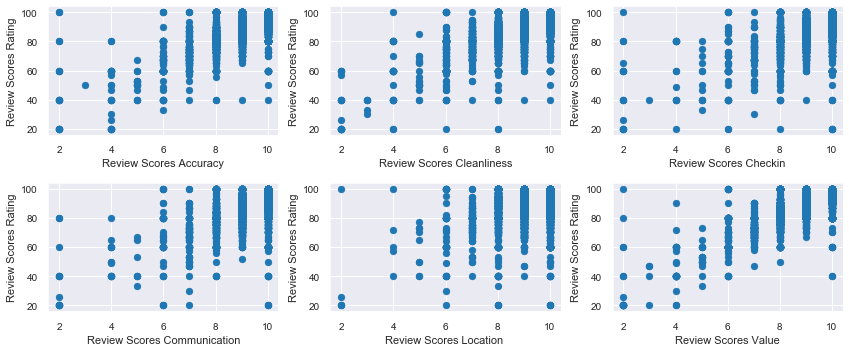

In [1591]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,5))
plt.subplot(2,3,1)


plt.tight_layout()
plt.scatter(y=numeric_features['Review Scores Rating'],x=numeric_features['Review Scores Accuracy'])
plt.ylabel('Review Scores Rating')
plt.xlabel('Review Scores Accuracy')

plt.subplot(2,3,2)
plt.tight_layout()
plt.scatter(y=numeric_features['Review Scores Rating'],x=numeric_features['Review Scores Cleanliness'])
plt.ylabel('Review Scores Rating')
plt.xlabel('Review Scores Cleanliness')

plt.subplot(2,3,3)
plt.tight_layout()
plt.scatter(y=numeric_features['Review Scores Rating'],x=numeric_features['Review Scores Checkin'])
plt.ylabel('Review Scores Rating')
plt.xlabel('Review Scores Checkin')

plt.subplot(2,3,4)
plt.tight_layout()
plt.scatter(y=numeric_features['Review Scores Rating'],x=numeric_features['Review Scores Communication'])
plt.ylabel('Review Scores Rating')
plt.xlabel('Review Scores Communication')

plt.subplot(2,3,5)
plt.tight_layout()
plt.scatter(y=numeric_features['Review Scores Rating'],x=numeric_features['Review Scores Location'])
plt.ylabel('Review Scores Rating')
plt.xlabel('Review Scores Location ')

plt.subplot(2,3,6)
plt.tight_layout()
plt.scatter(y=numeric_features['Review Scores Rating'],x=numeric_features['Review Scores Value'])
plt.ylabel('Review Scores Rating')
plt.xlabel('Review Scores Value')

plt.show()

Por lo tanto, puedo estar seguro de que puedo usar la Review Scores Rating para representar a los demás sin perder mucha información.

Vamos a analizar la correlación de la misma forma, la anterior, para el grupo de <b>Availability</b>.  
Usaremos el mismo método anterior.


In [1592]:
review_df = house_data_raw[['Availability 30','Availability 60', 'Availability 90', 'Availability 365']]
review_df2 = review_df.dropna()
y = review_df2['Availability 90'] 
x = review_df2.drop(['Availability 90'], axis=1 )
est = sm.OLS(y, x).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:        Availability 90   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          1.989e+05
Date:                Sun, 02 Feb 2020   Prob (F-statistic):                        0.00
Time:                        17:11:31   Log-Likelihood:                         -45221.
No. Observations:               13264   AIC:                                  9.045e+04
Df Residuals:                   13261   BIC:                                  9.047e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

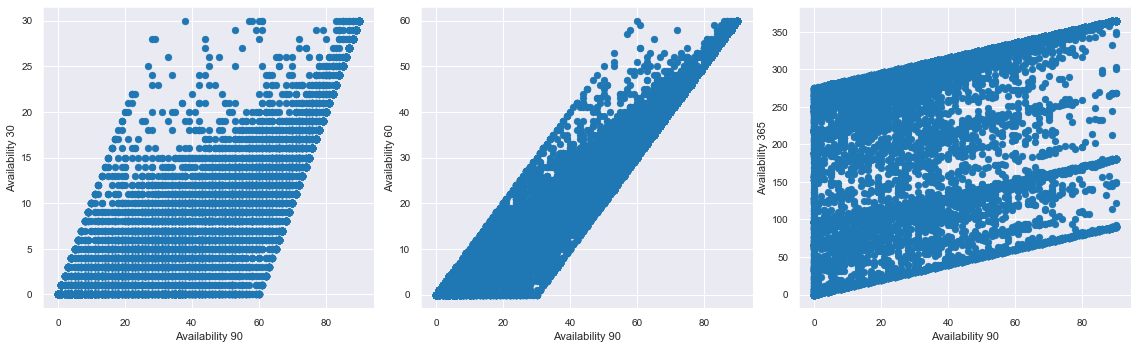

In [1593]:
sns.set_style('darkgrid')
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.tight_layout()
plt.scatter(x=combined['Availability 90'],y=combined['Availability 30'])
plt.xlabel('Availability 90')
plt.ylabel('Availability 30')

plt.subplot(1,3,2)
plt.tight_layout()
plt.scatter(x=combined['Availability 90'],y=combined['Availability 60'])
plt.xlabel('Availability 90')
plt.ylabel('Availability 60')

plt.subplot(1,3,3)
plt.tight_layout()
plt.scatter(x=combined['Availability 90'],y=combined['Availability 365'])
plt.xlabel('Availability 90')
plt.ylabel('Availability 365')
plt.show()

Podemos apreciar que existe una correlación entre la variable Availability 30 , Availability 60 y Availability 365. Nos quedaremos con Availability 90.

#### Accommodates, 	Bathrooms,	Bedrooms,	Beds, Guests Included

Podemos observar que las cuatro variables se comportan de una forma similar ante la variable Price.  
Bajo mi opinión considero que son variables de mucho peso a la hora de determinar el precio del alojamiento, por este motivo no realiza ningún tipo de operación.

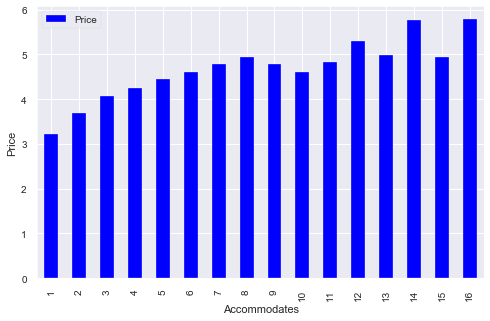

In [1594]:
#Accommodates vs Price 
figsize=(16,5)
quality_pivot = numeric_features.pivot_table(index='Accommodates', values='Price', aggfunc=np.median)
quality_pivot.plot(kind='bar',color='blue', figsize=(8,5))
plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.show()

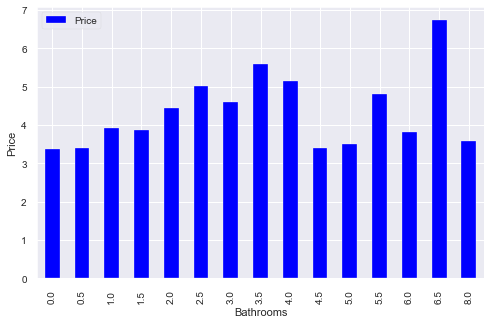

In [1595]:
# Cleaning Fee vs Price 
figsize=(16,5)
quality_pivot = numeric_features.pivot_table(index='Bathrooms', values='Price', aggfunc=np.median)
quality_pivot.plot(kind='bar',color='blue', figsize=(8,5))
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.show()

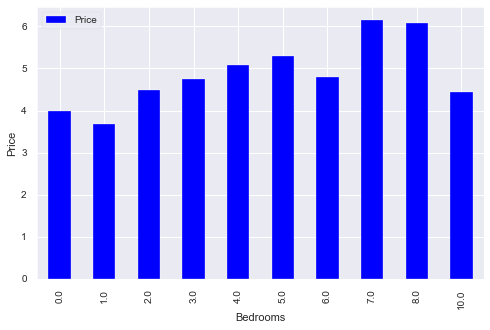

In [1596]:
# Bedrooms vs Price 
figsize=(16,5)
quality_pivot = numeric_features.pivot_table(index='Bedrooms', values='Price', aggfunc=np.median)
quality_pivot.plot(kind='bar',color='blue', figsize=(8,5))
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

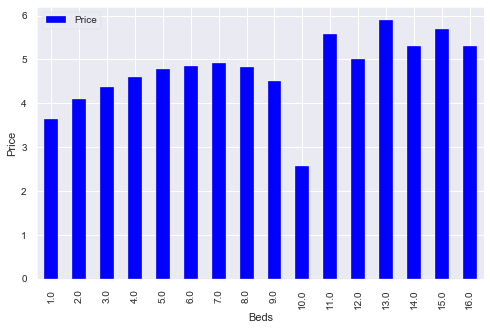

In [1597]:
# Beds vs Price 
figsize=(16,5)
quality_pivot = numeric_features.pivot_table(index='Beds', values='Price', aggfunc=np.median)
quality_pivot.plot(kind='bar',color='blue', figsize=(8,5))
plt.xlabel('Beds')
plt.ylabel('Price')
plt.show()

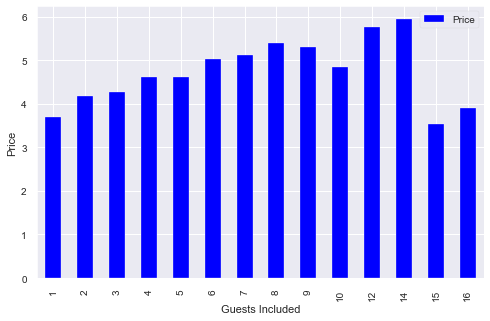

In [1598]:
# Beds vs Price - medium corr
figsize=(16,5)
quality_pivot = numeric_features.pivot_table(index='Guests Included', values='Price', aggfunc=np.median)
quality_pivot.plot(kind='bar',color='blue', figsize=(8,5))
plt.xlabel('Guests Included')
plt.ylabel('Price')
plt.show()

## 2.4 Detailed data analysis - Analysing continuous numeric variables
<a id="continuous"></a>

Análisis de las variables numéricas continuas ante la variable objetivo

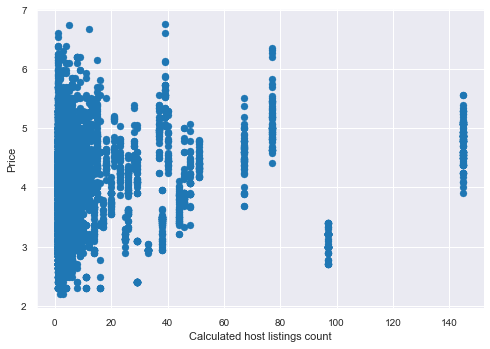

In [1599]:
#Calculated host listings count Vs Price
plt.scatter(x=X_train['Calculated host listings count'],y=y_train)
plt.xlabel('Calculated host listings count')
plt.ylabel('Price')
plt.show()

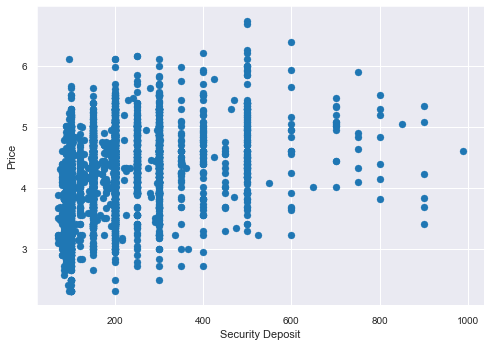

In [1600]:
#Security Deposit Vs Price
plt.scatter(x=X_train['Security Deposit'],y=y_train)
plt.xlabel('Security Deposit')
plt.ylabel('Price')
plt.show()

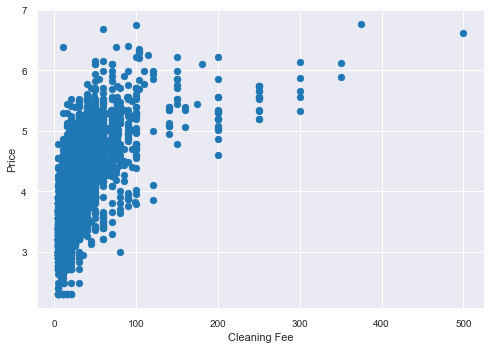

In [1601]:
#Cleaning Fee Vs Price
plt.scatter(x=X_train['Cleaning Fee'],y=y_train)
plt.xlabel('Cleaning Fee')
plt.ylabel('Price')
plt.show()

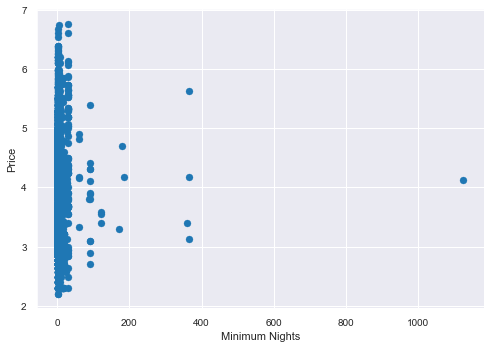

In [1602]:
#Minimum Nights Vs Price
plt.scatter(x=X_train['Minimum Nights'],y=y_train)
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.show()

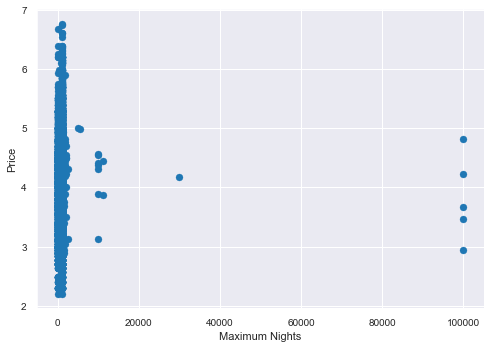

In [1603]:
#Maximum Nights Vs Price
plt.scatter(x=X_train['Maximum Nights'],y=y_train)
plt.xlabel('Maximum Nights')
plt.ylabel('Price')
plt.show()

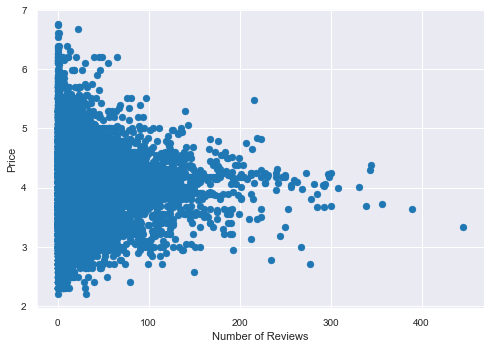

In [1604]:
#Number of Reviews Vs Price
plt.scatter(x=X_train['Number of Reviews'],y=y_train)
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.show()

In [1605]:
numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10611 entries, 8899 to 3261
Data columns (total 33 columns):
Host Response Rate                9283 non-null float64
Host Listings Count               10610 non-null float64
Host Total Listings Count         10610 non-null float64
Latitude                          10611 non-null float64
Longitude                         10611 non-null float64
Accommodates                      10611 non-null int64
Bathrooms                         10570 non-null float64
Bedrooms                          10594 non-null float64
Beds                              10569 non-null float64
Square Feet                       421 non-null float64
Weekly Price                      2682 non-null float64
Monthly Price                     2652 non-null float64
Security Deposit                  4528 non-null float64
Cleaning Fee                      6335 non-null float64
Guests Included                   10611 non-null int64
Extra People                      10611 non-n

Otro tipo de gráficos que nos ayudan a analizar conjuntamente

Text(0.5, 1.0, 'Maximum Nights')

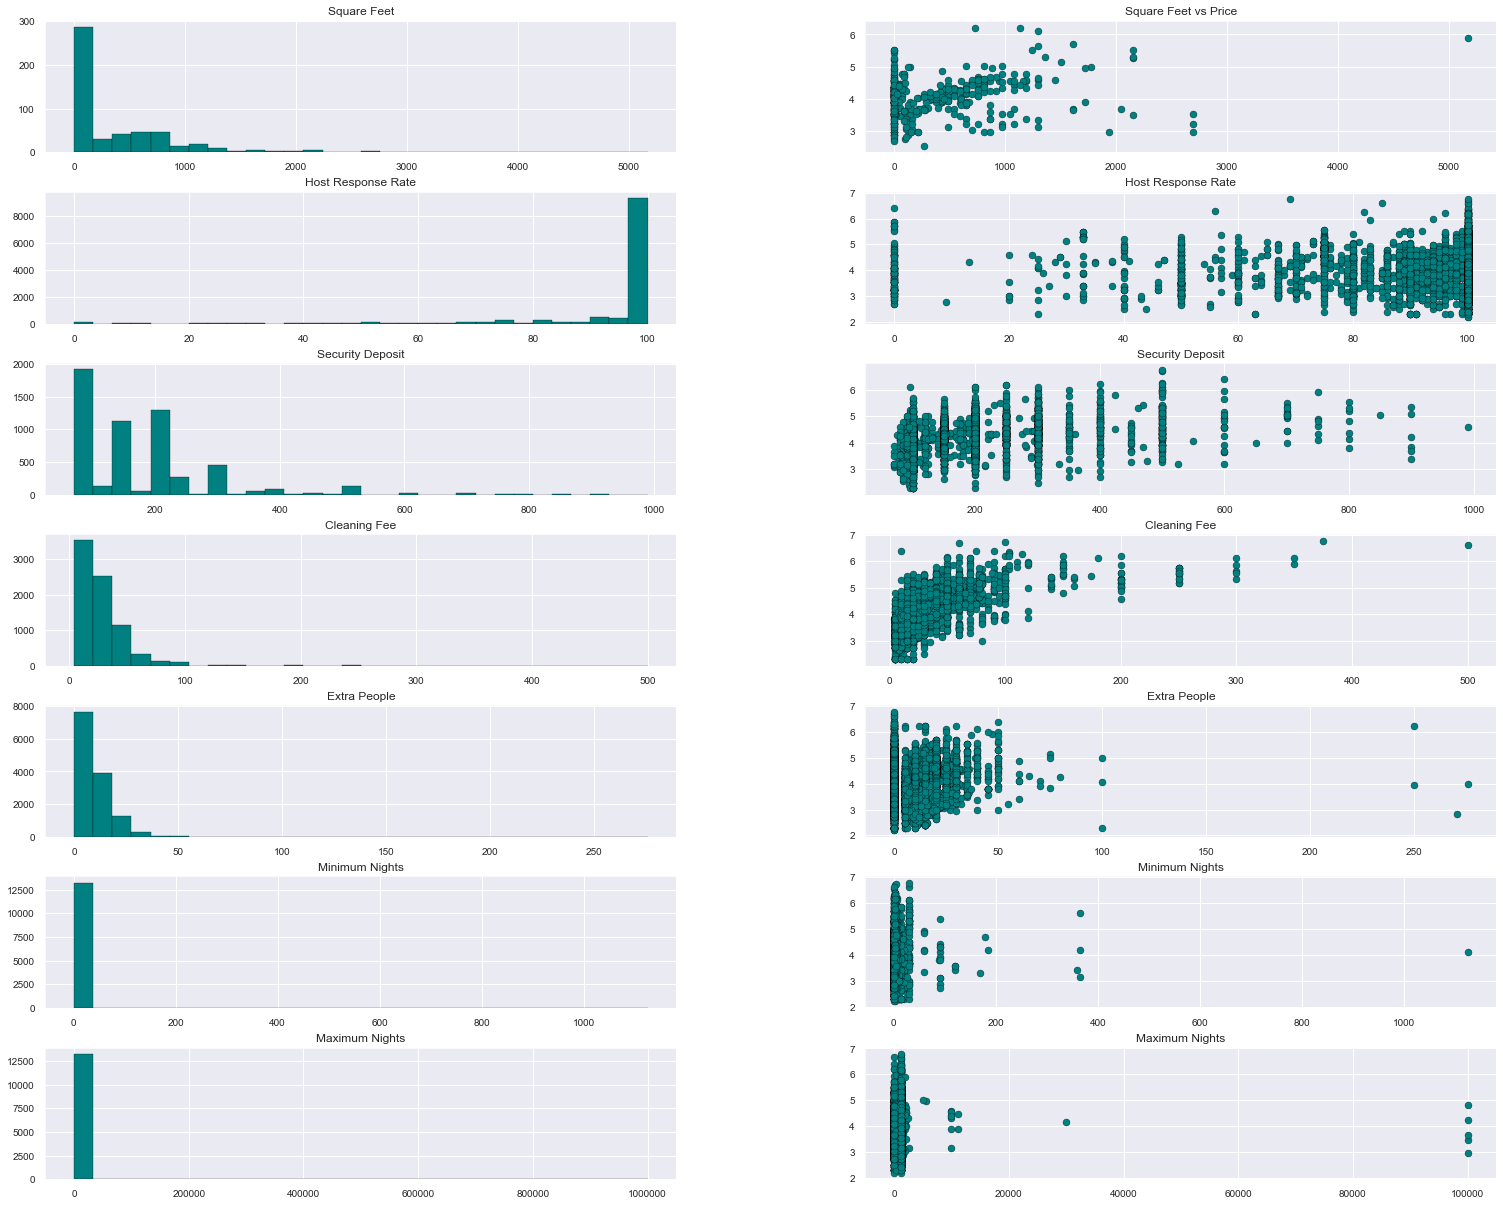

In [1606]:
sns.set_style('darkgrid')
plt.figure(figsize=(26,32))
plt.subplot(11,2,1)
plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.hist(combined['Square Feet'], bins=30, edgecolor= 'black',color ='teal')
plt.title('Square Feet')

plt.subplot(11,2,2)
plt.scatter(x=X_train['Square Feet'], y=y_train,edgecolor= 'black',color ='teal')
plt.title('Square Feet vs Price')

plt.subplot(11,2,3)
plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.hist(combined['Host Response Rate'], bins=30, edgecolor= 'black',color ='teal')
plt.title('Host Response Rate')

plt.subplot(11,2,4)
plt.scatter(x=X_train['Host Response Rate'], y=y_train,edgecolor= 'black',color ='teal')
plt.title('Host Response Rate')

plt.subplot(11,2,5)
plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.hist(combined['Security Deposit'], bins=30, edgecolor= 'black',color ='teal')
plt.title('Security Deposit')

plt.subplot(11,2,6)
plt.scatter(x=X_train['Security Deposit'], y=y_train,edgecolor= 'black',color ='teal')
plt.title('Security Deposit')

plt.subplot(11,2,7)
plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.hist(combined['Cleaning Fee'], bins=30, edgecolor= 'black',color ='teal')
plt.title('Cleaning Fee')

plt.subplot(11,2,8)
plt.scatter(x=X_train['Cleaning Fee'], y=y_train,edgecolor= 'black',color ='teal')
plt.title('Cleaning Fee')

plt.subplot(11,2,9)
plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.hist(combined['Extra People'], bins=30, edgecolor= 'black',color ='teal')
plt.title('Extra People')

plt.subplot(11,2,10)
plt.scatter(x=X_train['Extra People'], y=y_train,edgecolor= 'black',color ='teal')
plt.title('Extra People')

plt.subplot(11,2,11)
plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.hist(combined['Minimum Nights'], bins=30, edgecolor= 'black',color ='teal')
plt.title('Minimum Nights')

plt.subplot(11,2,12)
plt.scatter(x=X_train['Minimum Nights'], y=y_train,edgecolor= 'black',color ='teal')
plt.title('Minimum Nights')


plt.subplot(11,2,13)
plt.tight_layout()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
plt.hist(combined['Maximum Nights'], bins=30, edgecolor= 'black',color ='teal')
plt.title('Maximum Nights')

plt.subplot(11,2,14)
plt.scatter(x=X_train['Maximum Nights'], y=y_train,edgecolor= 'black',color ='teal')
plt.title('Maximum Nights')

In [1607]:
numeric_features.drop(['Price'], axis=1 , inplace= True)

# Observed Outliers
### Cleaning Fee > 300
### Extra People > 250
### Minimum Nigths > 1000
### Maximum Nigths > 2500


## 2.5 Detailed data analysis - Analysing categorical variables
<a id="categorical"></a>

Análisis de variables categóricas ante la característica target. Por ello añadimos dicha variable al conjunto de categoricals

In [1608]:
categoricals['Price'] = y_train

Host Response Time, variable no muy equilibrada.

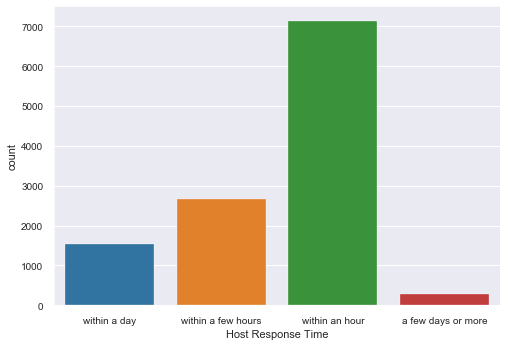

Text(0.5, 1.0, 'Price by Host Response time')

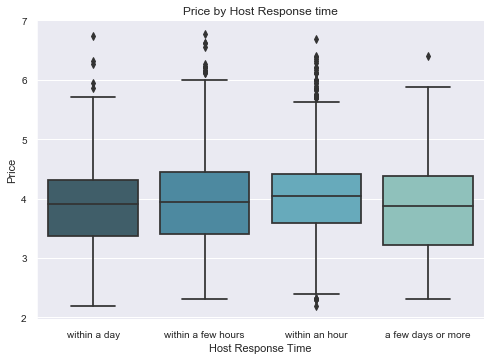

In [1609]:
#Host Response Time
sns.countplot(combined['Host Response Time'])
plt.show()
sns.boxplot(x = 'Host Response Time', y = 'Price', data = categoricals, palette= 'GnBu_d').set_title('Price by Host Response time')

Property Type, variable en la que recae todo el peso en su clase Apartment

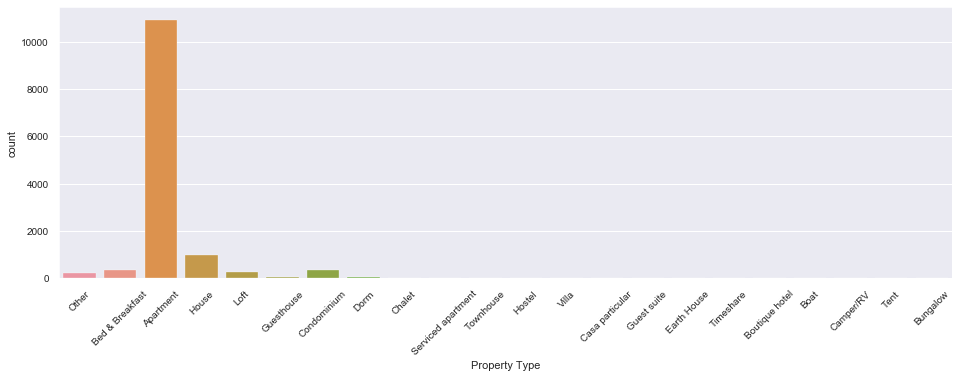

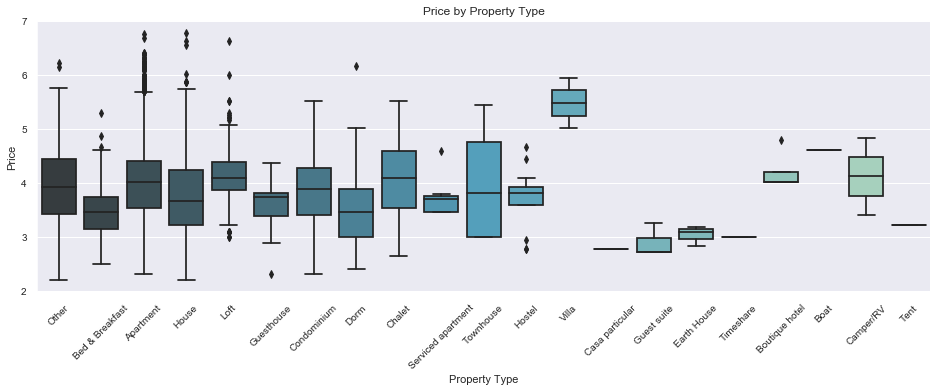

In [1610]:
# Property Type
fig, ax = plt.subplots(figsize=(16,5))
chart  = sns.countplot(combined['Property Type'], ax= ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()
fig, ax = plt.subplots(figsize=(16,5))
ax = sns.boxplot(x = 'Property Type', y = 'Price', data = categoricals, ax= ax, palette= 'GnBu_d').set_title('Price by Property Type')

#sns.set_palette("muted")
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.savefig('mvel_6turntypes.png', dpi=400, bbox_inches='tight')

Room Type, característica no equilibrada en sus tres clases siendo dos de ellas predominantes.

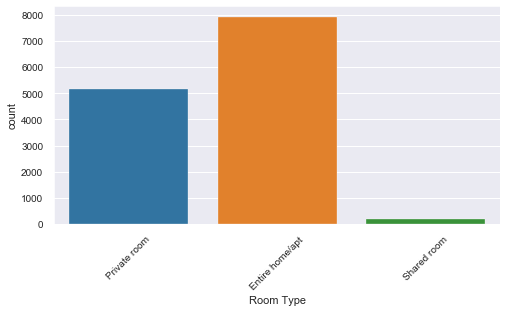

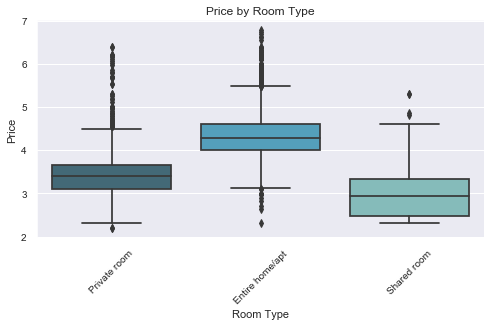

In [1611]:
# Room Type
fig, ax = plt.subplots(figsize=(8,4))
chart  = sns.countplot(combined['Room Type'], ax= ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.boxplot(x = 'Room Type', y = 'Price', data = categoricals, ax= ax, palette= 'GnBu_d').set_title('Price by Room Type')

#sns.set_palette("muted")
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.savefig('mvel_6turntypes.png', dpi=400, bbox_inches='tight')

Bed Type, clase principal Real Bed

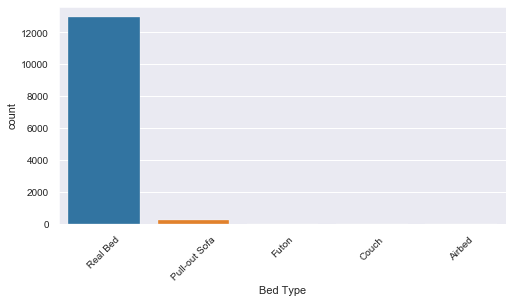

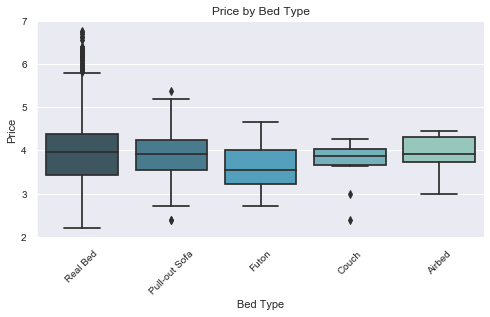

In [1612]:
# Bed Type
fig, ax = plt.subplots(figsize=(8,4))
chart  = sns.countplot(combined['Bed Type'], ax= ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.boxplot(x = 'Bed Type', y = 'Price', data = categoricals, ax= ax, palette= 'GnBu_d').set_title('Price by Bed Type')

#sns.set_palette("muted")
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.savefig('mvel_6turntypes.png', dpi=400, bbox_inches='tight')

ExperienceS Offered Policy, solo posee una clase

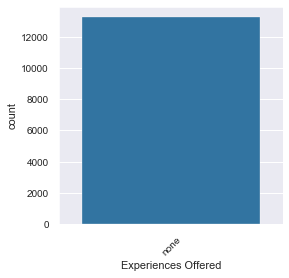

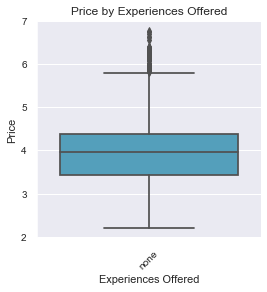

In [1613]:
# ExperienceS Offered Policy
fig, ax = plt.subplots(figsize=(4,4))
chart  = sns.countplot(combined['Experiences Offered'], ax= ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(4,4))
ax = sns.boxplot(x = 'Experiences Offered', y = 'Price', data = categoricals, ax= ax, palette= 'GnBu_d').set_title('Price by Experiences Offered')

#sns.set_palette("muted")
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.savefig('mvel_6turntypes.png', dpi=400, bbox_inches='tight')

# Solo una clase se procederá a eliminar

# 3 Feature Engineering
<a id="feature"></a>

## 3.0 Data Transformation - Drop columns
<a id="dropcolumn"></a>

Variables a eliminar despues del análisis

In [1614]:
columns_todrop =['Experiences Offered','Host Acceptance Rate','Square Feet','Has Availability','Review Scores Accuracy','Review Scores Cleanliness',
'Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value','License','Jurisdiction Names',
'Reviews per Month','Availability 60','Availability 365','Availability 30','Weekly Price','Monthly Price','Host Listings Count',
'Host Total Listings Count', 'Last Review', 'First Review']

In [1615]:
X_train.drop(columns_todrop, axis=1,inplace= True)
X_test.drop(columns_todrop, axis=1,inplace= True)

## 3.1 Data Transformation - Removing Outliers 
<a id="outlier"></a>

In [1616]:
#Outliers para Train

index_drop = X_train[X_train['Cleaning Fee']>300].index
index_drop = np.append(index_drop,X_train[X_train['Extra People']>250].index)
index_drop = np.append(index_drop,X_train[X_train['Maximum Nights']>2500].index)
index_drop = np.append(index_drop,X_train[X_train['Minimum Nights']>1000].index)     
X_train.drop(index_drop, inplace = True)
y_train.drop(index_drop, inplace = True)
print("{} examples in the training set are dropped.".format(len(index_drop)))

#Outliers para Test

index_drop = X_test[X_test['Cleaning Fee']>300].index
index_drop = np.append(index_drop,X_test[X_test['Extra People']>250].index)
index_drop = np.append(index_drop,X_test[X_test['Maximum Nights']>2500].index)
index_drop = np.append(index_drop,X_test[X_test['Minimum Nights']>1000].index)     
X_test.drop(index_drop, inplace = True)
y_test.drop(index_drop, inplace = True)
print("{} examples in the testing set are dropped.".format(len(index_drop)))


25 examples in the training set are dropped.
5 examples in the testing set are dropped.


## 3.2 Data Transformation - Dealing with categorical variables
<a id="cat2num"></a>

#### Cancellation Policy

In [1617]:
X_train['Cancellation Policy'].value_counts()

strict             3954
flexible           3413
moderate           3212
super_strict_60       5
super_strict_30       2
Name: Cancellation Policy, dtype: int64

In [1618]:
## Pasamos las clases super_stric_60 y super_stric_30 a strict
filtro = (X_train['Cancellation Policy'] == 'super_strict_60') | (X_train['Cancellation Policy'] == 'super_strict_30')
X_train['Cancellation Policy'][filtro] = 'strict'
#También en test
filtro = (X_test['Cancellation Policy'] == 'super_strict_60') | (X_test['Cancellation Policy'] == 'super_strict_30')
X_test['Cancellation Policy'][filtro] = 'strict'

In [1619]:
le = preprocessing.LabelEncoder()
le.fit(X_train['Cancellation Policy'])
X_train['Cancellation Policy'] = le.transform(X_train['Cancellation Policy']).astype('int64')
X_test['Cancellation Policy'] = le.transform(X_test['Cancellation Policy']).astype('int64')


#### Host Response Time

In [1620]:
X_train['Host Response Time'].value_counts()

within an hour        5686
within a few hours    2125
within a day          1248
a few days or more     202
Name: Host Response Time, dtype: int64

In [1621]:
X_train['Host Response Time'].isna().sum()

1325

In [1622]:
# los valores missing pasan al grupo N/D
X_train['Host Response Time'].fillna("N/D", inplace=True)

# Realizamos la misma acción en el conjunto de X_test
X_test['Host Response Time'].fillna("N/D", inplace=True)

In [1623]:
le = preprocessing.LabelEncoder()
le.fit(X_train['Host Response Time'])
X_train['Host Response Time'] = le.transform(X_train['Host Response Time']).astype('int64')
X_test['Host Response Time'] = le.transform(X_test['Host Response Time']).astype('int64')


#### Property Type

In [1624]:
X_train['Property Type'].value_counts()

Apartment             8729
House                  776
Bed & Breakfast        275
Condominium            261
Loft                   227
Other                  182
Dorm                    37
Guesthouse              30
Chalet                  20
Hostel                  13
Serviced apartment       9
Townhouse                9
Boutique hotel           4
Guest suite              3
Earth House              3
Camper/RV                2
Villa                    2
Casa particular          1
Timeshare                1
Tent                     1
Boat                     1
Name: Property Type, dtype: int64

Pasamos las clases con frecuencia por debajo de 250 a una clase llamada Other

In [1625]:
## Pasamos las clases con frecuencia por debajo de 250 a una clase llamada Other
filtro = (X_train['Property Type'] != 'Apartment') & (X_train['Property Type'] != 'House') & (X_train['Property Type'] != 'Bed & Breakfast')
X_train['Property Type'][filtro] = 'Other'
#También en test
filtro = (X_test['Property Type'] != 'Apartment') & (X_test['Property Type'] != 'House') & (X_test['Property Type'] != 'Bed & Breakfast')
X_test['Property Type'][filtro] = 'Other'

In [1626]:
le = preprocessing.LabelEncoder()
le.fit(X_train['Property Type'])
X_train['Property Type'] = le.transform(X_train['Property Type']).astype('int64')
X_test['Property Type'] = le.transform(X_test['Property Type']).astype('int64')


#### Room Type

In [1627]:
X_train['Room Type'].value_counts()


Entire home/apt    6342
Private room       4100
Shared room         144
Name: Room Type, dtype: int64

In [1628]:
## Pasamos las clases Shared room y Private room to Room
filtro = (X_train['Room Type'] == 'Private room') | (X_train['Room Type'] == 'Shared room')
X_train['Room Type'][filtro] = 'Room'
#También en test
filtro = (X_test['Room Type'] == 'Private room') | (X_test['Room Type'] == 'Shared room')
X_test['Room Type'][filtro] = 'Room'

In [1629]:
le = preprocessing.LabelEncoder()
le.fit(X_train['Room Type'])
X_train['Room Type'] = le.transform(X_train['Room Type']).astype('int64')
X_test['Room Type'] = le.transform(X_test['Room Type']).astype('int64')


#### Bed Type

In [1630]:
X_train['Bed Type'].value_counts()

Real Bed         10350
Pull-out Sofa      189
Futon               31
Couch               11
Airbed               5
Name: Bed Type, dtype: int64

In [1631]:
## Pasamos las clases ShareBed y Private Bed to Bed
filtro = (X_train['Bed Type'] != 'Real Bed') 
X_train['Bed Type'][filtro] = 'Other'
#También en test
filtro = (X_test['Bed Type'] != 'Real Bed') 
X_test['Bed Type'][filtro] = 'Other'

In [1632]:
le = preprocessing.LabelEncoder()
le.fit(X_train['Bed Type'])
X_train['Bed Type'] = le.transform(X_train['Bed Type']).astype('int64')
X_test['Bed Type'] = le.transform(X_test['Bed Type']).astype('int64')


#### Característica Calendar Updated

In [1633]:
X_train['Calendar Updated'].value_counts().head(10)

today           2741
yesterday        858
2 weeks ago      849
a week ago       828
3 days ago       636
4 days ago       509
2 months ago     411
5 days ago       388
3 weeks ago      387
4 weeks ago      313
Name: Calendar Updated, dtype: int64

In [1634]:
# Pasamos todas las clases en este calendario a 4 clases, también en test
X_train.loc[X_train['Calendar Updated'].str.contains('yesterday', na=False), 'Calendar Updated'] = 'yesterday'
X_train.loc[X_train['Calendar Updated'].str.contains('today', na=False), 'Calendar Updated'] = 'today'
X_train.loc[X_train['Calendar Updated'].str.contains('week', na=False), 'Calendar Updated'] = 'weeks'
X_train.loc[X_train['Calendar Updated'].str.contains('day', na=False), 'Calendar Updated'] = 'days'
X_train.loc[X_train['Calendar Updated'].str.contains('month', na=False), 'Calendar Updated'] = 'months'
X_test.loc[X_test['Calendar Updated'].str.contains('yesterday', na=False), 'Calendar Updated'] = 'yesterday'
X_test.loc[X_test['Calendar Updated'].str.contains('today', na=False), 'Calendar Updated'] = 'today'
X_test.loc[X_test['Calendar Updated'].str.contains('week', na=False), 'Calendar Updated'] = 'weeks'
X_test.loc[X_test['Calendar Updated'].str.contains('day', na=False), 'Calendar Updated'] = 'days'
X_test.loc[X_test['Calendar Updated'].str.contains('month', na=False), 'Calendar Updated'] = 'months'

In [1635]:
le = preprocessing.LabelEncoder()
le.fit(X_train['Calendar Updated'])
X_train['Calendar Updated'] = le.transform(X_train['Calendar Updated']).astype('int64')
X_test['Calendar Updated'] = le.transform(X_test['Calendar Updated']).astype('int64')


In [1636]:
X_train['Distancia Centro'] = distance(X_train['Latitude'],X_train['Longitude'], 40.4381311,-3.8196196 )
X_test['Distancia Centro'] = distance(X_test['Latitude'],X_test['Longitude'], 40.4381311,-3.8196196 )
X_train.drop(['Latitude', 'Longitude'], axis=1, inplace= True)
X_test.drop(['Latitude', 'Longitude'], axis=1, inplace= True)

## 3.3 Data Transformation - Imputing missing values
<a id="impute"></a>

In [1637]:
check_missing_data(X_train)

                                Total   Percent
Security Deposit                 6067  0.573115
Cleaning Fee                     4275  0.403835
Review Scores Rating             2291  0.216418
Host Response Rate               1325  0.125165
Amenities                          91  0.008596
Beds                               42  0.003968
Bathrooms                          41  0.003873
Bedrooms                           17  0.001606
Host Verifications                  6  0.000567
Host Since                          1  0.000094
Extra People                        0  0.000000
Accommodates                        0  0.000000
Host Response Time                  0  0.000000
Calculated host listings count      0  0.000000
Cancellation Policy                 0  0.000000
Neighbourhood Group Cleansed        0  0.000000
Property Type                       0  0.000000
Room Type                           0  0.000000
Number of Reviews                   0  0.000000
Guests Included                     0  0

In [1638]:
# Security Deposit  - Importante alto grado de valores missing (57%), no la eliminamos, considero que es una variable a tener en cuenta en la dtermianción del precio.
media = X_train['Security Deposit'].mean()
X_train['Security Deposit']= X_train['Security Deposit'].fillna(media)
X_test['Security Deposit'] = X_test['Security Deposit'].fillna(media)
print('')

In [1639]:
# Cleaning Fee   - Importante alto grado de valores missing (40%),no la eliminamos, considero que es una variable a tener en cuenta en la dtermianción del precio.
media = X_train['Cleaning Fee'].mean()
X_train['Cleaning Fee'] = X_train['Cleaning Fee'].fillna(media)
X_test['Cleaning Fee'] = X_test['Cleaning Fee'].fillna(media)
print('')

In [1640]:
# Review Scores Rating   - Importante alto grado de valores missing (40%), ver si es mejor quitar la característica
media = X_train['Review Scores Rating'].mean()
X_train['Review Scores Rating']= X_train['Review Scores Rating'].fillna(media)
X_test['Review Scores Rating']= X_test['Review Scores Rating'].fillna(media)
print('')

In [1641]:
# Host Response Rate   - Importante alto grado de valores missing (40%), ver si es mejor quitar la característica
media = X_train['Host Response Rate'].mean()
X_train['Host Response Rate']= X_train['Host Response Rate'].fillna(media)
X_test['Host Response Rate']=X_test['Host Response Rate'].fillna(media)
print('')

In [1642]:
# Beds  
mediana = X_train['Beds'].median()
X_train['Beds'].fillna(mediana, inplace= True)
X_test['Beds'].fillna(mediana,  inplace= True)
print('')

In [1643]:
# Bathrooms  
mediana = X_train['Bathrooms'].median()
X_train['Bathrooms'].fillna(mediana, inplace= True)
X_test['Bathrooms'].fillna(mediana,  inplace= True)
print('')

In [1644]:
# Bedrooms  
mediana = X_train['Bedrooms'].median()
X_train['Bedrooms'].fillna(mediana, inplace= True)
X_test['Bedrooms'].fillna(mediana,  inplace= True)
print('')

## 3.4 Data Transformation - Dealing with time variables
<a id="time"></a>

<h5>Característica 'Host Since'</h5>
Compuesta por Fechas. Voy a seguir el consejo recibido en el master y trabajar con un valor numérico más significativo que no producirá errores al aplicar algoritmos.
Para ello vamos a calcular el número de dias desde fecha actual hasta fecha Host Since. Doy por hecho que los alojamientos siguen en la plataforma a día de hoy.

In [1645]:
X_train['Host Since'].value_counts().head()

2014-09-19    127
2014-05-08     91
2016-01-12     67
2012-09-14     64
2017-02-23     54
Name: Host Since, dtype: int64

In [1646]:
# Convertimos a datetime
X_train['Host Since']= pd.to_datetime(X_train['Host Since']) 
X_test['Host Since']= pd.to_datetime(X_train['Host Since'])
now = datetime.now()

# Calculamos número de días para X_train
X_train['Host Dias Activo'] = (datetime(now.year, now.month, now.day) - X_train['Host Since']).astype('timedelta64[D]')

# Calculamos  número de días para X_test
X_test['Host Dias Activo'] = (datetime(now.year, now.month, now.day) - X_test['Host Since']).astype('timedelta64[D]')

# Calculamos media, mediana, y moda en X_train
print("Media de días como host:", round(X_train['Host Dias Activo'].mean(),0))
print("Mediana de días como host:", X_train['Host Dias Activo'].median())
print("Moda de días como host:", X_train['Host Dias Activo'].mode())

# Reemplazamos los valores null por la media de X_train en X_train y X_test
X_train['Host Dias Activo'].fillna(X_train['Host Dias Activo'].mean(), inplace=True)
X_test['Host Dias Activo'].fillna(X_train['Host Dias Activo'].mean(), inplace=True)

# Eliminamos la columna nativa 'Host Since' en X_train y X_test
X_train.drop(['Host Since'], axis=1, inplace=True)
X_test.drop(['Host Since'], axis=1, inplace=True)


Media de días como host: 1934.0
Mediana de días como host: 1818.0
Moda de días como host: 0    1962.0
dtype: float64


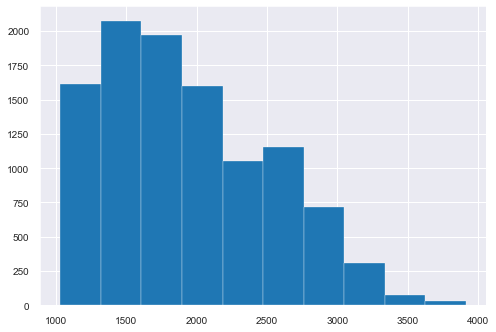

In [1647]:
X_train['Host Dias Activo'].hist()

## 3.5 Data Transformation - Categorical variables to dummy columns
<a id="dummy"></a>

In [1648]:
# Unimos los dataset de test y train para estas transformaciones
X_train['#train'] =1
X_test['#train']=0
completo = pd.concat([X_train,X_test])
ncolumns = len(completo.columns)

In [1649]:
# Codificamos con el metodo One Hot Neighbourhood Group Cleansed
ncolumns = completo.shape[1]
completo = OneH(completo,'Neighbourhood Group Cleansed')
completo.drop(['Neighbourhood Group Cleansed'], axis=1 , inplace= True)


<h3>Características Amenities</h3>  
Su info se compone de una enumeracion de características.  

Vamos a realizar un pequeño estudio y quedarnos por la info más frecuente en columnas o características en dataframe.


In [1650]:
completo['Amenities'].unique()[:3]
# Muestra de Amenities

array(['Wireless Internet,Kitchen,Heating,Washer,Essentials,Hangers,Hair dryer,Iron,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50',
       'Pets allowed,Family/kid friendly',
       'TV,Wireless Internet,Kitchen,Heating,Washer,Essentials,Shampoo,Hangers,Hair dryer,Laptop friendly workspace,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50'],
      dtype=object)

In [1651]:
# Amenities
amenities_list = list(completo['Amenities'])

amenities_list_string = " ".join(map(str,amenities_list))
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)


In [1652]:
amenities_set


{'24-hour check-in',
 '24-hour check-in Cable TV',
 '24-hour check-in Internet',
 '24-hour check-in TV',
 '24-hour check-in Wireless Internet',
 'Air conditioning',
 'Baby bath',
 'Baby bath TV',
 'Babysitter recommendations',
 'Babysitter recommendations TV',
 'Bathtub',
 'Bathtub Buzzer/wireless intercom',
 'Bathtub Internet',
 'Bathtub TV',
 'Bathtub Wireless Internet',
 'Bathtub nan TV',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Buzzer/wireless intercom Cable TV',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware Internet',
 'Children’s dinnerware TV',
 'Children’s dinnerware Wireless Internet',
 'Crib',
 'Crib Internet',
 'Crib TV',
 'Crib Wireless Internet',
 'Crib nan TV',
 'Crib translation missing: en.hosting_amenity_49',
 'Dog(s)',
 'Dog(s) TV',
 'Doorman',
 'Doorman Entry',
 'Doorman Entry Air conditioning',
 'Doorman Entry Internet',
 'Doorman Entry TV',
 'Doorman Entry Wireless Internet',
 'Door

En set anterior, algunos servicios son más importantes que otros, y es probable que algunos sean poco comunes. En base a la experiencia como cliente que cualquiera de nosotros podemos tener, se extraerá una selección de los servicios más importantes. Estos serán investigados más a fondo en el siguiente bloque de acción. Por ejemplo, si resulta que casi todas las propiedades tienen / no tienen una característica particular, esa característica no será muy útil para ayudar a explicar las diferencias en los precios.

Los servicios elegidos son:  

<b>*las barras indican categorías separadas que se pueden combinar</b>

'Check in 24h',
'AC',
'Electrónica Gama Alta',
 'Barbacoa',
 'Balcón',
'Vistas/Situación',
'Ropa de cama' ,
'Desayuno',
 'TV',
 'Cafetera',
'Utensilios Cocina',
h'Lavadora/Secadora',
'Ascensor',
'Gimnasio',
'Child Friendly',
'Parking',
'Espacio Outdoor',
'Host Greetings',
'Hidromasaje/Sauna/Piscina',
 'Internet',
'Estancias de larga duración',
'Mascotas',
'Entrada Privada',
'Seguridad',
'Auto Check in',
'Permitido Fumar',
'Accessible',
 'Adecuado para eventos',

In [1653]:
# Almacenamos en una variable el size actual de columns
ncolumns = completo.shape[1]
ncolumns

48

In [1654]:
completo.loc[completo['Amenities'].str.contains('24-hour check-in', na=False), 'Check in 24h'] = 1
completo.loc[completo['Amenities'].str.contains('Air conditioning|Central air conditioning', na=False), 'AC'] = 1
completo.loc[completo['Amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV', na=False),'Electrónica Gama Alta'] = 1
completo.loc[completo['Amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque', na=False), 'Barbacoa'] = 1
completo.loc[completo['Amenities'].str.contains('Balcony|Patio', na=False), 'Balcón'] = 1
completo.loc[completo['Amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront', na=False), 'Vistas/Situación'] = 1
completo.loc[completo['Amenities'].str.contains('Bed linens', na=False), 'Ropa de cama' ] = 1
completo.loc[completo['Amenities'].str.contains('Breakfast', na=False), 'Desayuno'] = 1
completo.loc[completo['Amenities'].str.contains('TV', na=False), 'TV'] = 1
completo.loc[completo['Amenities'].str.contains('Coffee maker|Espresso machine', na=False), 'Cafetera'] = 1
completo.loc[completo['Amenities'].str.contains('Cooking basics', na=False), 'Utensilios Cocina'] = 1
completo.loc[completo['Amenities'].str.contains('Dishwasher|Dryer|Washer', na=False), 'Lavadora/Secadora'] = 1
completo.loc[completo['Amenities'].str.contains('Elevator', na=False), 'Ascensor'] = 1
completo.loc[completo['Amenities'].str.contains('Exercise equipment|Gym|gym', na=False), 'Gimnasio'] = 1
completo.loc[completo['Amenities'].str.contains('Family/kid friendly|Children|children', na=False), 'Child Friendly'] = 1
completo.loc[completo['Amenities'].str.contains('parking', na=False), 'Parking'] = 1
completo.loc[completo['Amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace', na=False), 'Espacio Outdoor'] = 1
completo.loc[completo['Amenities'].str.contains('Host greets you', na=False), 'Host Greetings'] = 1
completo.loc[completo['Amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool', na=False), 'Hidromasaje/Sauna/Piscina'] = 1
completo.loc[completo['Amenities'].str.contains('Internet|Pocket wifi|Wifi', na=False), 'Internet'] = 1
completo.loc[completo['Amenities'].str.contains('Long term stays allowed', na=False), 'Estancias de larga duración'] = 1
completo.loc[completo['Amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)', na=False), 'Mascotas'] = 1
completo.loc[completo['Amenities'].str.contains('Private entrance', na=False), 'Entrada Privada'] = 1
completo.loc[completo['Amenities'].str.contains('Safe|Security system', na=False), 'Seguridad'] = 1
completo.loc[completo['Amenities'].str.contains('Self check-in', na=False), 'Auto Check in'] = 1
completo.loc[completo['Amenities'].str.contains('Smoking allowed', na=False), 'Permitido Fumar'] = 1
completo.loc[completo['Amenities'].str.contains('Step-free access|Wheelchair|Accessible', na=False), 'Accessible'] = 1
completo.loc[completo['Amenities'].str.contains('Suitable for events', na=False), 'Adecuado para eventos'] = 1

In [1655]:
completo["Total Amenities"]= completo.iloc[:, ncolumns:].sum(axis=1)

In [1656]:
# Tratamiento valores Nan
cols_to_replace_nulls = completo.iloc[:,ncolumns:].columns
completo[cols_to_replace_nulls] = completo[cols_to_replace_nulls].fillna(0)

# Creamos una lista de características donde si detectamos si contiene menos del 10% de los alojamientos
No_Frecuentes = []
Frecuentes = []
for col in completo.iloc[:,ncolumns:].columns:
    if completo[col].sum() < len(completo)/10 or (completo[col].sum() ==  len(completo)) or completo[col].sum() == 0:
        No_Frecuentes.append(col)
    else:
        Frecuentes.append(col)
print('Variables NO frecuentes a eliminar: ',No_Frecuentes)

# Borramos características en menos del 10% de alojamientos
completo.drop(No_Frecuentes, axis=1, inplace=True)

# Borramos la columna Amenities 
completo.drop(['Amenities'], axis=1, inplace=True)


#Cambiamos el tipo de dato a int
for x in Frecuentes:
    completo[x]= completo[x].astype(np.uint8)
    
# Presentamos resúmen
completo.iloc[:,ncolumns:].head(5)

Variables NO frecuentes a eliminar:  ['Electrónica Gama Alta', 'Barbacoa', 'Balcón', 'Vistas/Situación', 'Ropa de cama', 'Cafetera', 'Utensilios Cocina', 'Gimnasio', 'Parking', 'Espacio Outdoor', 'Host Greetings', 'Hidromasaje/Sauna/Piscina', 'Estancias de larga duración', 'Entrada Privada', 'Auto Check in', 'Adecuado para eventos']


AC  Desayuno  TV  Lavadora/Secadora  Ascensor  Child Friendly  Internet  \
8899   0         0   0                  1         0               0         1   
1236   0         0   0                  0         0               1         0   
2945   0         0   1                  1         0               0         1   
2384   1         1   0                  1         1               0         1   
8874   0         0   1                  1         0               0         1   

      Mascotas  Seguridad  Permitido Fumar  Accessible  Total Amenities  
8899         0          0                0           0                2  
1236         1          0                0           0                2  
2945         0          0                0           0                3  
2384         0          0                0           0                5  
8874         0          0                0           0                3

<h3>Características Features</h3>  
Su info se compone de una enumeracion de características.  

Vamos a realizar un pequeño estudio y quedarnos por la info más frecuente en columnas o características en dataframe.


In [1657]:
completo['Features'].unique()[3]

'Host Has Profile Pic,Host Identity Verified,Requires License,Instant Bookable'

In [1658]:
# Features
features_list = list(completo['Features'])
features_list_string = " ".join(map(str,features_list))
features_list_string = features_list_string.replace('{', '')
features_list_string = features_list_string.replace('}', ',')
features_list_string = features_list_string.replace('"', '')
features_set = [x.strip() for x in features_list_string.split(',')]
features_set = set(features_set)



In [1659]:
features_set

{'Host Has Profile Pic',
 'Host Identity Verified',
 'Instant Bookable',
 'Instant Bookable Host Has Profile Pic',
 'Instant Bookable Host Is Superhost',
 'Instant Bookable Is Location Exact',
 'Instant Bookable Requires License',
 'Instant Bookable Requires License Host Has Profile Pic',
 'Is Location Exact',
 'Require Guest Phone Verification Host Has Profile Pic',
 'Require Guest Phone Verification Host Is Superhost',
 'Require Guest Profile Picture',
 'Require Guest Profile Picture Host Has Profile Pic',
 'Require Guest Profile Picture Host Is Superhost',
 'Requires License',
 'Requires License Host Has Profile Pic',
 'Requires License Host Is Superhost',
 'Requires License Is Location Exact',
 'Requires License Requires License',
 'Requires License Requires License Host Has Profile Pic',
 'Requires License Requires License Host Is Superhost'}

Actuamos de la misma forma que la característica Amenities.   
Serían estas categorias.

'Host Has Profile Pic',
'Host Is Superhost',
'Host Identity Verified',
'Instant Bookable',
'Is Location Exact',
'Require Guest Phone Verification',
'Require Guest Profile Picture',
'Requires License'

In [1660]:
# Almacenamos en una variable el size actual de columns
ncolumns = completo.shape[1]
ncolumns

60

In [1661]:
# completo
completo.loc[completo['Features'].str.contains('Host Has Profile Pic', na=False), 'Host Has Profile Pic'] = 1
completo.loc[completo['Features'].str.contains('Host Is Superhost', na=False), 'Host Is Superhost'] = 1
completo.loc[completo['Features'].str.contains('Host Identity Verified', na=False), 'Host Identity Verified'] = 1
completo.loc[completo['Features'].str.contains('Instant Bookable', na=False), 'Instant Bookable'] = 1
completo.loc[completo['Features'].str.contains('Is Location Exact', na=False), 'Is Location Exact'] = 1
completo.loc[completo['Features'].str.contains('Require Guest Phone Verification', na=False), 'Require Guest Phone Verification'] = 1
completo.loc[completo['Features'].str.contains('Require Guest Profile Picture', na=False), 'Require Guest Profile Picture'] = 1
completo.loc[completo['Features'].str.contains('Requires License', na=False), 'Requires License'] = 1


In [1662]:
completo["Total Features"]= completo.iloc[:, ncolumns:].sum(axis=1)

Exactamente como Amenities, tratamiento de Nan, lista con los No frecuentes (recordemos menos del 10% de alojamientos), eliminacion de la columna nativa Features.

In [1663]:
# Tratamiento valores Nan
cols_to_replace_nulls = completo.iloc[:,ncolumns:].columns
completo[cols_to_replace_nulls] = completo[cols_to_replace_nulls].fillna(0)

# Creamos una lista de características donde si detectamos si contiene menos del 10% de los alojamientos
No_Frecuentes = []
Frecuentes = []
for col in completo.iloc[:,ncolumns:].columns:
    if completo[col].sum() < len(completo)/10 or (completo[col].sum() ==  len(completo)) or completo[col].sum() == 0:
        No_Frecuentes.append(col)
    else:
        Frecuentes.append(col)
print('Variables NO frecuentes a eliminar: ',No_Frecuentes)

# Borramos características en menos del 10% de alojamientos
completo.drop(No_Frecuentes, axis=1, inplace=True)

# Borramos la columna Amenities 
completo.drop(['Features'], axis=1, inplace=True)


#Cambiamos el tipo de dato a int
for x in Frecuentes:
    completo[x]= completo[x].astype(np.uint8)
    
# Presentamos resúmen
completo.iloc[:,ncolumns:].head(5)


Variables NO frecuentes a eliminar:  ['Require Guest Phone Verification', 'Require Guest Profile Picture', 'Requires License']


Host Is Superhost  Host Identity Verified  Instant Bookable  \
8899                  0                       1                 0   
1236                  0                       0                 0   
2945                  0                       0                 0   
2384                  0                       0                 0   
8874                  0                       1                 0   

      Is Location Exact  Total Features  
8899                  1               4  
1236                  0               2  
2945                  1               3  
2384                  0               2  
8874                  1               4

In [1664]:
completo.shape

(13234, 65)

<h3>Características Host Verifications</h3>  
Su info se compone de una enumeracion de características.  
Vamos a realizar un pequeño estudio y quedarnos por la info más frecuente en columnas o características en dataframe.



In [1665]:
ncolumns = completo.shape[1]
ncolumns

65

In [1666]:
completo['Host Verifications'].unique()[3]

'email,phone,facebook,reviews'

In [1667]:
# Features
features_list = list(completo['Host Verifications'])
features_list_string = " ".join(map(str,features_list))
features_list_string = features_list_string.replace('{', '')
features_list_string = features_list_string.replace('}', ',')
features_list_string = features_list_string.replace('"', '')
features_set = [x.strip() for x in features_list_string.split(',')]
features_set = set(features_set)

In [1668]:
features_set

{'amex',
 'email',
 'facebook',
 'facebook email',
 'facebook phone',
 'facebook phone email',
 'google',
 'google email',
 'google phone',
 'government_id',
 'government_id None email',
 'government_id email',
 'government_id email email',
 'government_id phone',
 'government_id phone email',
 'government_id reviews',
 'government_id reviews email',
 'identity_manual',
 'identity_manual email',
 'identity_manual phone',
 'identity_manual phone email',
 'jumio',
 'jumio None email',
 'jumio email',
 'jumio email email',
 'jumio facebook email',
 'jumio nan email',
 'jumio phone',
 'jumio phone email',
 'jumio phone phone',
 'jumio reviews',
 'jumio reviews email',
 'kba',
 'kba email',
 'kba phone',
 'kba phone email',
 'linkedin',
 'manual_offline',
 'manual_offline email',
 'manual_offline phone',
 'manual_offline phone email',
 'manual_online',
 'offline_government_id',
 'phone',
 'phone email',
 'phone email email',
 'phone phone',
 'phone phone email',
 'phone reviews email',
 'ph

In [1669]:
# completo
completo.loc[completo['Host Verifications'].str.contains('amex', na=False), 'Host Verifications amex'] = 1
completo.loc[completo['Host Verifications'].str.contains('email', na=False), 'Host Verifications emal'] = 1
completo.loc[completo['Host Verifications'].str.contains('facebook', na=False), 'Host Verifications facebook'] = 1
completo.loc[completo['Host Verifications'].str.contains('google', na=False), 'Host Verifications google'] = 1
completo.loc[completo['Host Verifications'].str.contains('government_id', na=False), 'Host Verifications government_id'] = 1
completo.loc[completo['Host Verifications'].str.contains('identity_manual', na=False), 'Host Verifications identity_manual'] = 1
completo.loc[completo['Host Verifications'].str.contains('jumio', na=False), 'Host Verifications jumio'] = 1
completo.loc[completo['Host Verifications'].str.contains('kba', na=False), 'Host Verifications kba'] = 1
completo.loc[completo['Host Verifications'].str.contains('linkedin', na=False), 'Host Verifications linkedin'] = 1
completo.loc[completo['Host Verifications'].str.contains('manual', na=False), 'Host Verifications manual'] = 1
completo.loc[completo['Host Verifications'].str.contains('phone', na=False), 'Host Verifications phone'] = 1
completo.loc[completo['Host Verifications'].str.contains('photographer', na=False), 'Host Verifications photographer'] = 1
completo.loc[completo['Host Verifications'].str.contains('reviews', na=False), 'Host Verifications reviews'] = 1
completo.loc[completo['Host Verifications'].str.contains('selfie', na=False), 'Host Verifications selfie'] = 1
completo.loc[completo['Host Verifications'].str.contains('sent_id', na=False), 'Host Verifications sent_id'] = 1
completo.loc[completo['Host Verifications'].str.contains('weibo', na=False), 'Host Verifications weibo'] = 1
completo.loc[completo['Host Verifications'].str.contains('work_email', na=False), 'Host Verifications work_email'] = 1

In [1670]:
completo["Total Host Verifications"]= completo.iloc[:, ncolumns:].sum(axis=1)

In [1671]:
# Tratamiento valores Nan
cols_to_replace_nulls = completo.iloc[:,ncolumns:].columns
completo[cols_to_replace_nulls] = completo[cols_to_replace_nulls].fillna(0)

# Creamos una lista de características donde si detectamos si contiene menos del 10% de los alojamientos
No_Frecuentes = []
Frecuentes = []
for col in completo.iloc[:,ncolumns:].columns:
    if completo[col].sum() < len(completo)/10 or (completo[col].sum() ==  len(completo)) or completo[col].sum() == 0:
        No_Frecuentes.append(col)
    else:
        Frecuentes.append(col)
print('Variables NO frecuentes a eliminar: ',No_Frecuentes)

# Borramos características en menos del 10% de alojamientos
completo.drop(No_Frecuentes, axis=1, inplace=True)

# Borramos la columna Amenities 
completo.drop(['Host Verifications'], axis=1, inplace=True)


#Cambiamos el tipo de dato a int
for x in Frecuentes:
    completo[x]= completo[x].astype(np.uint8)
    
# Presentamos resúmen
completo.iloc[:,ncolumns:].head(5)

Variables NO frecuentes a eliminar:  ['Host Verifications amex', 'Host Verifications google', 'Host Verifications identity_manual', 'Host Verifications kba', 'Host Verifications linkedin', 'Host Verifications manual', 'Host Verifications photographer', 'Host Verifications selfie', 'Host Verifications sent_id', 'Host Verifications weibo', 'Host Verifications work_email']


Host Verifications facebook  Host Verifications government_id  \
8899                            0                                 1   
1236                            0                                 1   
2945                            0                                 0   
2384                            1                                 0   
8874                            1                                 0   

      Host Verifications jumio  Host Verifications phone  \
8899                         1                         1   
1236                         1                         0   
2945                         0                         1   
2384                         0                         1   
8874                         1                         1   

      Host Verifications reviews  Total Host Verifications  
8899                           1                         5  
1236                           0                         3  
2945                           1                         3  
2384                           1                         4  
8874                           0                         4

In [1741]:
# Volvemos a separar
X_train = completo[completo['#train']== 1]
X_test = completo[completo['#train']== 0]

In [1673]:
# Eliminamos columna auxiliar #train
X_train.drop(['#train'], inplace= True, axis= 1)
X_test.drop(['#train'], inplace= True, axis= 1)

In [1674]:
# Normalizamos y  Standarizamos
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
scaler = StandardScaler().fit(X_train_norm)
X_train_s = scaler.transform(X_train_norm)
X_train_s = pd.DataFrame(X_train_s, index=X_train.index, columns=X_train.columns)
X_test_s = scaler.transform(X_test_norm)
X_test_s = pd.DataFrame(X_test_s, index=X_test.index, columns=X_test.columns)

In [1675]:
# Copia Backup, pendiente de usar
X_train_sB = X_train_s.copy()
X_test_sB = X_test_s.copy()

## 3.6 Final Dataset- Dropping unimportant features with XGBoost
<a id="toomany"></a>

Selección de características importantes

In [1676]:
print('Número de columnas: ',X_train_s.shape[1])

Número de columnas:  70


In [1677]:
xgb = XGBRegressor(objective='reg:squarederror')

In [1678]:
xgb.fit(X_train_s, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [1679]:
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train_s.columns)
imp = imp.sort_values(['Importance'], ascending = False)
print(imp)

                                                    Importance
Room Type                                             0.642214
Bathrooms                                             0.089214
AC                                                    0.024854
Accommodates                                          0.024593
Bedrooms                                              0.017398
...                                                        ...
Neighbourhood Group Cleansed_#_Retiro                 0.000000
Neighbourhood Group Cleansed_#_Moratalaz              0.000000
Neighbourhood Group Cleansed_#_Fuencarral - El ...    0.000000
Neighbourhood Group Cleansed_#_Ciudad Lineal          0.000000
Lavadora/Secadora                                     0.000000

[70 rows x 1 columns]


In [1680]:
rmse = make_scorer(rmse, greater_is_better=False)

In [1681]:
rfecv = RFECV(estimator=xgb, step=1, cv=3, n_jobs=-1, scoring=rmse, verbose = 2)
rfecv = rfecv.fit(X_train_s, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

Nos quedaríamos en 34 variables

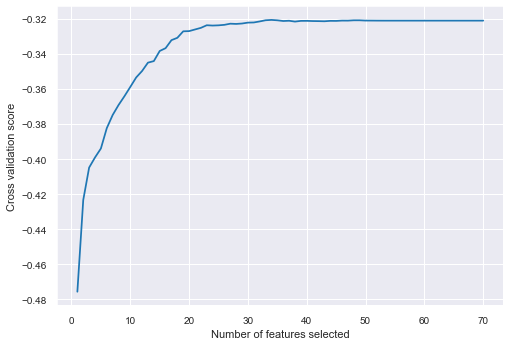

In [1682]:
#Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.xticks(np.arange(0,200,10))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

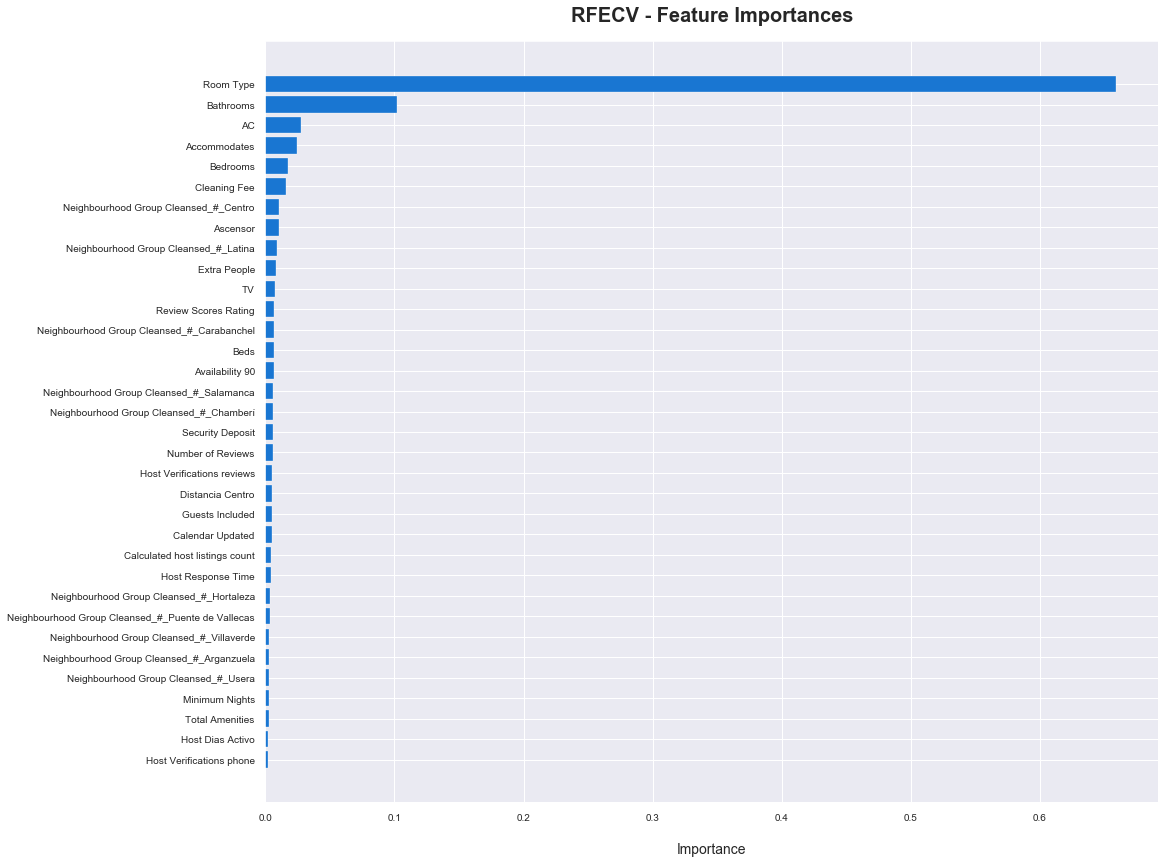

In [1684]:
dset = pd.DataFrame()
dset['attr'] = X_train_s.columns.values[rfecv.support_] 
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=True)
plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [1690]:
features_kept = X_train_s.columns.values[rfecv.support_] 

X_tr = X_train_s[features_kept]
X_ts = X_test_s[features_kept]

# 4. Machine Learning
<a id="machine"></a>

## 4.1 Linear Regression
<a id="linear"></a>

In [1691]:
# Linear Regression

from regressors import stats
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_tr, y_train)## 4.1 Lasso Regression
<a id="lasso"></a>## 4.2 Lasso Regression
<a id="lasso"></a>

y_train_ols = ols.predict(X_tr)
y_test_ols = ols.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, y_train_ols))
print('Resultado conjunto test: ',r2_score(y_test, y_test_ols))

#Guardmos resultados
GuardaResultado('Linear Regression',r2_score(y_train, y_train_ols),r2_score(y_test, y_test_ols))

Resultado conjunto train:  0.7168959080126751
Resultado conjunto test:  0.7004724272849543


## 4.2 Lasso Regression
<a id="lasso"></a>

In [1693]:
#Lasso Regression with RandomizedSearchCV

lasso = Lasso()
alpha_vector= [0.00001,0.0001, 0.025,0.05,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
params_lasso={'alpha':alpha_vector}
lasso_random = RandomizedSearchCV(estimator = lasso, param_distributions = params_lasso,
                               n_iter=100, cv=10, n_jobs=-1,random_state=42, verbose=2)
lasso_random.fit(X_tr, y_train)
print("best mean cross-validation score: {}".format(lasso_random.best_score_))
print("best parameters: {}".format(lasso_random.best_params_))

lasso001 = Lasso()
lasso001.set_params(**lasso_random.best_params_)
lasso001.fit(X_tr, y_train)## 4.1 Lasso Regression
<a id="lasso"></a>
ytrainLasso = lasso001.predict(X_tr)
ytestLasso  = lasso001.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, ytrainLasso))
print('Resultado conjunto test: ',r2_score(y_test, ytestLasso))

#Guardmos resultados
GuardaResultado('Lasso Regression with RandomizedSearchCV',r2_score(y_train, ytrainLasso),r2_score(y_test, ytestLasso))


Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best mean cross-validation score: 0.714047547342507
best parameters: {'alpha': 0.0001}
Resultado conjunto train:  0.716894977777367
Resultado conjunto test:  0.700521725251318


[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    2.6s finished


## 4.3 Ridge Regression
<a id="ridge"></a>

In [1694]:
#Ridge with GridSearchCV

alpha_vector = np.logspace(-15,100,25)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5, verbose= 1)
grid.fit(X_tr, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

rd = Ridge()
rd.set_params(**grid.best_params_)
rd.fit(X_tr, y_train)
ytrain_rd = rd.predict(X_tr)
ytest_rd = rd.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, ytrain_rd))
print('Resultado conjunto test: ',r2_score(y_test, ytest_rd))

#Guardmos resultados
GuardaResultado('Ridge Regression with GridSearchCV',r2_score(y_train, ytrain_rd),r2_score(y_test, ytest_rd))




Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best mean cross-validation score: -0.127
best parameters: {'alpha': 0.23713737056616552}
Resultado conjunto train:  0.7168959076997553
Resultado conjunto test:  0.7004730764896647


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.7s finished


In [1695]:
dfResultados

Algoritmo     Train      Test
0  Lasso Regression with RandomizedSearchCV  0.716895  0.700522
1                         Linear Regression  0.716896  0.700472
2        Ridge Regression with GridSearchCV  0.716896  0.700473

## 4.4 Randomforest Regression
<a id="random"></a>

In [1697]:
#Randomforest with RandomSearchCV

rf = RandomForestRegressor(random_state = 42)

#Hyperparamater tuning using RandomSearchCV

random_grid = { 
    'n_estimators': [int(x) for x in np.linspace(start = 600, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,6,7,8,9,10],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1, 2]
}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5,
                               verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_tr, y_train)
print(rf_random.best_params_)
print(rf_random.best_score_)

rf = RandomForestRegressor()## 4.1 Lasso Regression
<a id="lasso"></a>
rf.set_params(**rf_random.best_params_)
rf.fit(X_tr, y_train)
y_train_rf = rf.predict(X_tr)
y_test_rf = rf.predict(X_ts)


print('Resultado conjunto train: ',r2_score(y_train, y_train_rf))
print('Resultado conjunto test: ',r2_score(y_test, y_test_rf))

#Guardamos resultados
GuardaResultado('Randomforest with RandomSearchCV',r2_score(y_train, y_train_rf),r2_score(y_test, y_test_rf))




Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.3min finished


{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10}
0.7616072766947719
Resultado conjunto train:  0.8451170413599656
Resultado conjunto test:  0.7541453999704678


In [1700]:
#Randomforest with GridSearchCV
#Atención, duración 85 min.

param_grid = { 
    'n_estimators': [int(x) for x in np.linspace(start = 600, stop = 2000, num = 10)],
    'max_features': ['auto'],
    'max_depth' : [3,5,6],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1, 2]
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = 6, verbose = 2)

grid_search.fit(X_tr, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

rf = RandomForestRegressor()
rf.set_params(**rf_random.best_params_)
rf.fit(X_tr, y_train)
y_train_rf = rf.predict(X_tr)
y_test_rf = rf.predict(X_ts)


print('Resultado conjunto train: ',r2_score(y_train, y_train_rf))
print('Resultado conjunto test: ',r2_score(y_test, y_test_rf))

#Guardamos resultados
GuardaResultado('Randomforest with GridSearchCV',r2_score(y_train, y_train_rf),r2_score(y_test, y_test_rf))



Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 600 out of 600 | elapsed: 37.9min finished


{'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
0.7205263094750459
Resultado conjunto train:  0.8456830382526908
Resultado conjunto test:  0.7535566055629908


## 4.5 SVM Regression
<a id="svm"></a>

In [1701]:
#SVM with RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svr = SVR()
params = {'gamma':  np.logspace(-5, 1, 4), 'C': np.logspace(-2, 2, 10)}
search_cv = RandomizedSearchCV(svr, param_distributions=params, n_iter=100, n_jobs= 6## 4.1 Lasso Regression
<a id="lasso"></a>, verbose = 2, cv = 5)
search_cv.fit(X_tr, y_train)
print(search_cv.best_params_)
print(search_cv.best_score_)

svr= SVR()
svr.set_params(**search_cv.best_params_)
svr.fit(X_tr, y_train)
y_train_svr = svr.predict(X_tr)
y_test_svr = svr.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, y_train_svr))
print('Resultado conjunto test: ',r2_score(y_test, y_test_svr))

#Guardamos resultados
GuardaResultado('SVM with RandomizedSearchCV',r2_score(y_train, y_train_svr),r2_score(y_test, y_test_svr))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   28.3s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:  4.2min finished


{'gamma': 0.001, 'C': 35.93813663804626}
0.7539815914376476
Resultado conjunto train:  0.7809750479952732
Resultado conjunto test:  0.7457615404415545


In [1702]:
#SVM with GridSearchCV

svr = SVR()
params = {'gamma': np.logspace(-5, 1, 8), 'C':  np.logspace(-2, 2, 10)}
search_cv = GridSearchCV(svr, param_grid=params, n_jobs= 6, verbose = 2, cv = 5)
search_cv.fit(X_tr, y_train)
print(search_cv.best_params_)
print(search_cv.best_score_)

svr= SVR()
svr.set_params(**search_cv.best_params_)
svr.fit(X_tr, y_train)
y_train_svr = svr.predict(X_tr)
y_test_svr = svr.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, y_train_svr))
print('Resultado conjunto test: ',r2_score(y_test, y_test_svr))

#Guardamos resultados
GuardaResultado('SVM with GridSearchCV',r2_score(y_train, y_train_svr),r2_score(y_test, y_test_svr))



Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   26.2s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed:  9.6min finished


{'C': 1.6681005372000592, 'gamma': 0.026826957952797246}
0.7680093563041339
Resultado conjunto train:  0.8623554491676213
Resultado conjunto test:  0.7552664559340345


In [1703]:
dfResultados

Algoritmo     Train      Test
0  Lasso Regression with RandomizedSearchCV  0.716895  0.700522
1                         Linear Regression  0.716896  0.700472
2        Ridge Regression with GridSearchCV  0.716896  0.700473
3          Randomforest with RandomSearchCV  0.845117  0.754145
4            Randomforest with GridSearchCV  0.845683  0.753557
5               SVM with RandomizedSearchCV  0.780975  0.745762
6                     SVM with GridSearchCV  0.862355  0.755266

## 4.6 GradientBoosting Regression
<a id="gradient"></a>

In [1704]:
#GradientBoostingRegressor with GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor


learningRate = [0.1,0.05,0.025] 
loss = ['ls', 'lad', 'huber']
n_estimators = [500, 1000]
max_depth = [3, 5]# mantenemos max_depth estático: max_depth=3
min_samples_leaf = [1, 2] 
min_samples_split = [2, 4]
## 4.1 Lasso Regression
<a id="lasso"></a>


hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features,
    'learning_rate':learningRate}

grid = GridSearchCV(GradientBoostingRegressor(), param_grid=hyperparameter_grid, cv = 5, n_jobs=6, verbose = 2)
grid.fit(X_tr, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

gbr = GradientBoostingRegressor()
gbr.set_params(**grid.best_params_)
gbr.fit(X_tr, y_train)
y_train_gbr = gbr.predict(X_tr)
y_test_gbr = gbr.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, y_train_gbr))
print('Resultado conjunto test: ',r2_score(y_test, y_test_gbr))

#Guardmos resultados
GuardaResultado('GradientBoostingRegressor with GridSearchCV',r2_score(y_train, y_train_gbr),r2_score(y_test, y_test_gbr))




Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   40.5s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed: 26.0min finished


best mean cross-validation score: 0.794
best parameters: {'learning_rate': 0.025, 'loss': 'ls', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Resultado conjunto train:  0.8861646719010772
Resultado conjunto test:  0.784467745277468


In [1705]:
dfResultados

Algoritmo     Train      Test
0     Lasso Regression with RandomizedSearchCV  0.716895  0.700522
1                            Linear Regression  0.716896  0.700472
2           Ridge Regression with GridSearchCV  0.716896  0.700473
3             Randomforest with RandomSearchCV  0.845117  0.754145
4               Randomforest with GridSearchCV  0.845683  0.753557
5                  SVM with RandomizedSearchCV  0.780975  0.745762
6                        SVM with GridSearchCV  0.862355  0.755266
7  GradientBoostingRegressor with GridSearchCV  0.886165  0.784468

In [1729]:
#GradientBoostingRegressor with RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint as sp_randInt 
from scipy.stats import uniform as sp_randFloat


model = GradientBoostingRegressor()
parameters = {'learning_rate':  [0.1,0.05,0.025,0.001] ,
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(100, 1000),
                  'max_depth'    : sp_randInt(3,7) 
                 }
grid = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                               cv = 5, n_iter = 100, n_jobs=6, verbose= 2)


grid.fit(X_tr, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

gbr = GradientBoostingRegressor()
gbr.set_params(**grid.best_params_) 
gbr.fit(X_tr, y_train)
y_train_gbr = gbr.predict(X_tr)
y_test_gbr = gbr.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, y_train_gbr))
print('Resultado conjunto test: ',r2_score(y_test, y_test_gbr))

#Guardmos resultados
GuardaResultado('GradientBoostingRegressor with RandomizedSearchCV',r2_score(y_train, y_train_gbr),r2_score(y_test, y_test_gbr))



Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   50.5s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed: 12.8min finished


best mean cross-validation score: 0.797
best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 890, 'subsample': 0.7395402846929516}
Resultado conjunto train:  0.8910829522540321
Resultado conjunto test:  0.7804889525563592


In [1730]:
dfResultados

Algoritmo     Train      Test
0           Lasso Regression with RandomizedSearchCV  0.716895  0.700522
1                                  Linear Regression  0.716896  0.700472
2                 Ridge Regression with GridSearchCV  0.716896  0.700473
3                   Randomforest with RandomSearchCV  0.845117  0.754145
4                     Randomforest with GridSearchCV  0.845683  0.753557
5                        SVM with RandomizedSearchCV  0.780975  0.745762
6                              SVM with GridSearchCV  0.862355  0.755266
7        GradientBoostingRegressor with GridSearchCV  0.886165  0.784468
8  GradientBoostingRegressor with RandomizedSearchCV  0.891083  0.780489
9      DecisionTreeRegressor with RandomizedSearchCV  0.916018  0.787426

## 4.7 Decision Tree Regression
<a id="tree"></a>

In [1728]:
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint

param_dist = {"max_depth": randint(1, 9),
              "max_features": randint(1, 20),GradientBoostingRegressor## 4.6 GradientBoosting Regression
<a id="gradient"></a>
              "min_samples_leaf": randint(1, 9)
             }

tree = DecisionTreeRegressor()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5, n_iter = 100, n_jobs=6, verbose= 2)
tree_cv.fit(X_tr, y_train)

print("best mean cross-validation score: {:.3f}".format(tree_cv.best_score_))
print("best parameters: {}".format(tree_cv.best_params_))

tree = DecisionTreeRegressor()
tree.set_params(**tree_cv.best_params_)
tree.fit(X_tr, y_train)
y_train_tre = gbr.predict(X_tr)
y_test_tre = gbr.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, y_train_tre))
print('Resultado conjunto test: ',r2_score(y_test, y_test_tre))

#Guardmos resultados
GuardaResultado('DecisionTreeRegressor with RandomizedSearchCV',r2_score(y_train, y_train_tre),r2_score(y_test, y_test_tre))



Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 218 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    1.5s finished


best mean cross-validation score: 0.696
best parameters: {'max_depth': 8, 'max_features': 17, 'min_samples_leaf': 3}
Resultado conjunto train:  0.9160176661305874
Resultado conjunto test:  0.7874256007905458


In [1733]:
param_dist = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2,3, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100]
             }

tree = DecisionTreeRegressor()
tree_cv = GridSearchCV(tree, param_dist, cv=5, n_jobs=6, verbose= 2)
tree_cv.fit(X_tr, y_train)

print("best mean cross-validation score: {:.3f}".format(tree_cv.best_score_))
print("best parameters: {}".format(tree_cv.best_params_))

tree = DecisionTreeRegressor()
tree.set_params(**tree_cv.best_params_)
tree.fit(X_tr, y_train)
y_train_tre = gbr.predict(X_tr)
y_test_tre = gbr.predict(X_ts)

print('Resultado conjunto train: ',r2_score(y_train, y_train_tre))
print('Resultado conjunto test: ',r2_score(y_test, y_test_tre))

#Guardmos resultados
GuardaResultado('DecisionTreeRegressor with GridSearchSearchCV',r2_score(y_train, y_train_tre),r2_score(y_test, y_test_tre))




Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 761 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 964 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 1080 out of 1080 | elapsed:  5.5min finished


best mean cross-validation score: 0.708
best parameters: {'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}
Resultado conjunto train:  0.8910829522540321
Resultado conjunto test:  0.7804889525563592


In [1734]:
dfResultados

Algoritmo     Train      Test
0            Lasso Regression with RandomizedSearchCV  0.716895  0.700522
1                                   Linear Regression  0.716896  0.700472
2                  Ridge Regression with GridSearchCV  0.716896  0.700473
3                    Randomforest with RandomSearchCV  0.845117  0.754145
4                      Randomforest with GridSearchCV  0.845683  0.753557
5                         SVM with RandomizedSearchCV  0.780975  0.745762
6                               SVM with GridSearchCV  0.862355  0.755266
7         GradientBoostingRegressor with GridSearchCV  0.886165  0.784468
8   GradientBoostingRegressor with RandomizedSearchCV  0.891083  0.780489
9       DecisionTreeRegressor with RandomizedSearchCV  0.916018  0.787426
10      DecisionTreeRegressor with GridSearchSearchCV  0.891083  0.780489

# 5. Conclusion
<a id="conclusion"></a>

El puntaje R cuadrado en el conjunto de prueba todavía no está por encima de 0.8. Creo que puede deberse a un par de razones, a más importante es que la muestra de datos es demasiado pequeña (solo alrededor de 14000).  
Es difícil dibujar un patrón generalizado con este pequeño tamaño de muestra y eso también conduce a un sobreajuste en el conjunto de entrenamiento (Decision Tree).   
Una forma de solucionar esto es obtener más datos de listado de Airbnb para otras ciudades para aumentar las muestras de datos.

*Este práctica ha sido orientada por las muchas horas en kaggle y medium.  
Disculpas por adelantado por la demora en la entrega de la práctica, pero entre trabajo y un par de percances personales/familiares no he conseguido entregarla en tiempo y forma.